# **Hackathon Project: Driving Strategic Import Reforms through Advanced Analytics**

## **1. Introduction**

This project addresses Nigeria’s strategic goal of achieving **technological sovereignty and sustainable economic growth** by reforming its national import strategy—specifically focusing on **electrical machinery imports (HS Code 85)**. Leveraging historical import and tax data, this analysis aims to uncover patterns, risks, and opportunities that can inform **evidence-based government interventions** in areas such as **import substitution, taxation reform, innovation investment, and trade policy**.

Using a combination of **descriptive analytics, predictive modeling, and policy simulation**, the notebook is structured around the four core pillars of the hackathon challenge:

- **Strategic Import Dependency Analysis**  
  Evaluates Nigeria’s reliance on specific HS codes and supplier countries. It highlights dominant import partners, trends in import volume/value, and potential geopolitical or economic risks.

- **Taxation Optimization & Revenue Leakage**  
  Investigates discrepancies between CIF values and collected taxes. This section identifies the tax gap, explores under-declaration risks, and recommends reforms to enhance customs efficiency and revenue generation.

- **Predictive Forecasting of Import Volume & Tax Revenue**  
  Develops forecasting models to project future import volumes and tax revenues over the next 3–5 years. It simulates scenarios such as import reductions or shifts in supplier dominance to assess potential fiscal implications.

- **Policy Impact Modeling for Import Substitution & Innovation**  
  Assesses the impact of substituting key imports with local alternatives. This section estimates the fiscal and industrial effects of 20–30% import reduction in strategic categories and offers data-driven guidance for allocating innovation funds.

By combining insights from these four areas, the analysis supports the formulation of **targeted policies** that reduce import dependency, strengthen local industry, and enhance Nigeria's fiscal resilience in a rapidly evolving global trade environment.


## **2. Exploratory Data Analysis**

### **2.1 Data Overview**

In [ ]:
# import neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LinearRegression

import logging
logging.getLogger('prophet').setLevel(logging.CRITICAL)
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
from prophet import Prophet

# mount google drive
from google.colab import drive

In [ ]:
# Load cleaned dataset
file_path = '/content/drive/MyDrive/ZTH_Hackathon/clean_data.xlsx'
data = pd.read_excel(file_path)

In [ ]:
print('Shape of the data', data.shape)
data.head()


Shape of the data (110369, 14)


,Custom_Office,Reg_Number,Reg_Date,Importer,Importer_Code,Item_Nbr,HS_Code,HS_Description,FOB_Value(N),CIF_Value(N),Total_Tax(N),Mass(KG),Country_of_Origin,Country_of_Supply
0,PORT HARCOURT(3) ONNE,C33563,03/09/2019,0. C. CHRIS & CO,22228166-0001,1\2,8513100000,Lamps Designed To Function By Their Own Source...,880200,1069001,308512,10000,China,China
1,TIN CAN ISLAND,C102199,19/08/2019,08 EXPRESS SERVICES,22319106-0001,4\4,8528739000,"Reception Apparatus For Television, Monochrome...",652000,652000,189374,2000,United States,United States
2,TIN CAN ISLAND,C90075,24/07/2019,08 EXPRESS SERVICES,22319106-0001,4\4,8528739000,"Reception Apparatus For Television, Monochrome...",489000,489000,142031,2000,United States,United States
3,TIN CAN ISLAND,C33952,25/03/2019,08 EXPRESS SERVICES,22319106-0001,4\4,8509800000,Other Electromechanical Domestic Appliance,341524,341524,99198,2000,United Kingdom,United Kingdom
4,APAPA PORT,C11025,18/02/2019,08 EXPRESS SERVICES,22319106-0001,4\4,8509800000,Other Electromechanical Domestic Appliance,200001,200001,58095,4300,United Kingdom,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110369 entries, 0 to 110368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Custom_Office      110369 non-null  object
 1   Reg_Number         110369 non-null  object
 2   Reg_Date           110369 non-null  object
 3   Importer           110369 non-null  object
 4   Importer_Code      110369 non-null  object
 5   Item_Nbr           110369 non-null  object
 6   HS_Code            110369 non-null  int64 
 7   HS_Description     110369 non-null  object
 8   FOB_Value(N)       110369 non-null  int64 
 9   CIF_Value(N)       110369 non-null  int64 
 10  Total_Tax(N)       110369 non-null  int64 
 11  Mass(KG)           110369 non-null  int64 
 12  Country_of_Origin  110369 non-null  object
 13  Country_of_Supply  110369 non-null  object
dtypes: int64(5), object(9)
memory usage: 11.8+ MB


### **2.2 Data Cleaning**

In [ ]:
# check for missing values
data.isnull().sum()

,0
Custom_Office,0
Reg_Number,0
Reg_Date,0
Importer,0
Importer_Code,0
Item_Nbr,0
HS_Code,0
HS_Description,0
FOB_Value(N),0
CIF_Value(N),0


In [ ]:
# check for duplicates
data.duplicated().sum()

np.int64(0)

In [ ]:
# correct column data type
data['HS_Code'] = data['HS_Code'].astype(str)
# create month column
data['Reg_Date'] = pd.to_datetime(data['Reg_Date'], format='%d/%m/%Y')
data['Month'] = data['Reg_Date'].dt.month_name()

In [ ]:
# Drop irrelevant columns
data = data.drop(['Importer_Code', 'Mass(KG)'], axis=1)

### **2.3 Descriptive Statistics and Categorical Analysis**

In [ ]:
# describe numerical columns
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Reg_Date,110369,2019-06-28 16:44:36.229738240,2019-01-01 00:00:00,2019-04-01 00:00:00,2019-06-27 00:00:00,2019-09-24 00:00:00,2019-12-31 00:00:00,NaN
FOB_Value(N),110369.0,6566459.039332,3.0,100066.0,395422.0,2388224.0,8533609044.0,55862234.812967
CIF_Value(N),110369.0,7101979.306889,3.0,106117.0,473331.0,2860808.0,8711132280.0,57598642.069639
Total_Tax(N),110369.0,907528.219645,0.0,19182.0,69624.0,333188.0,1060982907.0,7512687.990578


In [ ]:
cat_cols = ['Custom_Office', 'Importer', 'HS_Code', 'Country_of_Origin', 'Country_of_Supply']

# Get unique counts for each categorical columns
for col in cat_cols:
    print(f"{col}: {data[col].nunique()} unique values")

Custom_Office: 17 unique values
Importer: 9910 unique values
HS_Code: 301 unique values
Country_of_Origin: 153 unique values
Country_of_Supply: 158 unique values


### **2.4 Exploratory Data Analysis (EDA) Summary**

#### **Dataset Overview**
- **Records**: 110,369 transactions (1 year coverage)
- **Key Features**:
  - `Importer`, `HS_Code`, `CIF_Value(N)`, `Total_Tax(N)`
- **Data Quality**: Zero missing values/duplicates detected

#### **Key Insights**
**1. Trade Diversity**
- **Importers**: **9,910** unique entities (high fragmentation)
- **Products**: **301** unique HS Codes

**2. Global Trade Network**
- **Origins**: **153** source countries
- **Supply Routes**: **158** supplying countries
- **Top Trade Partners**:
  - China
  - India
  - UK

**3. Financial Profile**

| Metric          | Average Value |
|-----------------|--------------|
| CIF Value       | ₦7.1M        |
| Tax Paid        | ₦907K        |

(See Sections 3–6 for dependency, tax gap, and forecasting analysis.)

## **3. Strategic Import Dependency Analysis**

### **3.1 Key Metric: Total Import Value**

In [ ]:
# Calculate total Cost, Insurance and Frieght (CIF) Value
total_cif = data['CIF_Value(N)'].sum()
print(f"Total CIF Value of Imports: {total_cif:,.2f} Naira")

Total CIF Value of Imports: 783,838,354,122.00 Naira


### **3.2 Import Concentration by HS Code**

In [ ]:
# Proportion of imports by HS codes

# By frequency
hs_freq = data.groupby(['HS_Code', 'HS_Description']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
total_freq = hs_freq['Count'].sum()
hs_freq['percent'] = ((hs_freq['Count'] / total_freq) * 100).round(2)
print("Top HS Codes by Frequency of import:\n")
hs_freq.head()

Top HS Codes by Frequency of import:



,HS_Code,HS_Description,Count,percent
130,8517120000,Telephones For Cellular Networks Or For Other ...,13378,12.12
133,8517620000,"Machines For Reception, Conversion And Transmi...",6154,5.58
49,8504409000,Other Static Converters Not Specified,5139,4.66
237,8537100000,"Boards, Panels, Consoles For Electric Control/...",3316,3.00
232,8536500000,Other Electrical Switches,2914,2.64


In [ ]:
# By CIF value
hs_value = data.groupby(['HS_Code', 'HS_Description'])['CIF_Value(N)'].sum().reset_index(name='CIF_Value').sort_values(by='CIF_Value', ascending=False)

hs_value['%_of_Total_CIF'] = ((hs_value['CIF_Value'] / total_cif) * 100).round(2)
print("\nTop HS Codes by CIF Value:\n")
hs_value.head(10)


Top HS Codes by CIF Value:



,HS_Code,HS_Description,CIF_Value,%_of_Total_CIF
133,8517620000,"Machines For Reception, Conversion And Transmi...",102279539056,13.05
191,8528721000,"Reception Apparatus For Television, Coloured, ...",41962385894,5.35
17,8502121000,"Gen. Set, Diesel Or Semidiesel Engine, Output ...",36393600840,4.64
49,8504409000,Other Static Converters Not Specified,33122740574,4.23
34,8502392000,Gaspowered Generator,26380077578,3.37
268,8541401000,Solar Cells Whether Or Not In Modules Or Made ...,26094463458,3.33
237,8537100000,"Boards, Panels, Consoles For Electric Control/...",22859138707,2.92
135,8517700000,Parts Of Article Of Heading 8517,20756282745,2.65
290,8544600000,"Other Electric Conductors, For A Voltage Excee...",18173775432,2.32
131,8517180000,Other Telephone Sets Not Specified.,18034472021,2.30


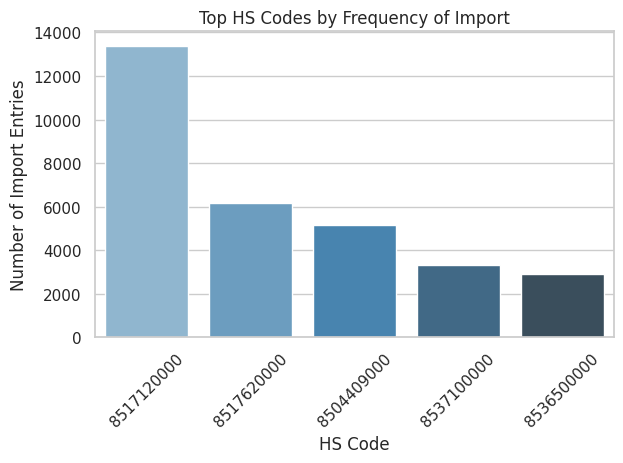

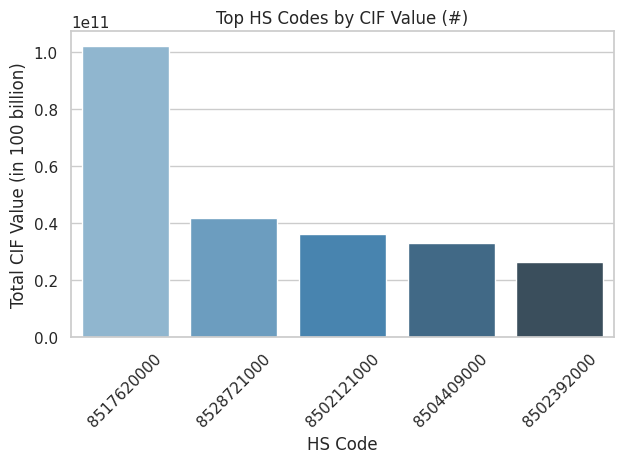

In [ ]:
# Visualize top HS Codes
sns.set(style="whitegrid")

# by Frequency
top_hs_freq = hs_freq.head(5)
sns.barplot(x='HS_Code', y='Count', data=top_hs_freq, palette='Blues_d', hue='HS_Code')
plt.title('Top HS Codes by Frequency of Import')
plt.xlabel('HS Code')
plt.ylabel('Number of Import Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top HS Codes by CIF (#) Value
top_hs_value = hs_value.head(5)
sns.barplot(x='HS_Code', y='CIF_Value', data=top_hs_value, hue='HS_Code', palette='Blues_d')
plt.title('Top HS Codes by CIF Value (#)')
plt.xlabel('HS Code')
plt.ylabel('Total CIF Value (in 100 billion)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **3.3 Import Concentration by Country of Origin**

In [ ]:
# import proportion of source country

# by frequency
origin_freq = data['Country_of_Origin'].value_counts().reset_index()
origin_freq['%_of_Total'] = ((origin_freq['count'] / total_freq) * 100).round(2)

print("Top Countries of Origin by frequency:\n")
origin_freq.head()

Top Countries of Origin by frequency:



,Country_of_Origin,count,%_of_Total
0,China,34421,31.19
1,United States,23840,21.60
2,Germany,9765,8.85
3,United Kingdom,6733,6.10
4,Netherlands,4018,3.64


In [ ]:
# By CIF Value
origin_value = data.groupby('Country_of_Origin')['CIF_Value(N)'].sum().sort_values(ascending=False).reset_index()
origin_value['%_of_Total_CIF'] = ((origin_value['CIF_Value(N)'] / total_cif) * 100).round(2)

print("Top Countries of Origin by CIF_Value:\n")
origin_value.head(10)

Top Countries of Origin by CIF_Value:



,Country_of_Origin,CIF_Value(N),%_of_Total_CIF
0,China,424295637937,54.13
1,India,70097676199,8.94
2,United Kingdom,47445462065,6.05
3,United States,38758997642,4.94
4,Italy,19866446869,2.53
5,Germany,19123720341,2.44
6,South Korea,18657417091,2.38
7,Hong Kong,16502647771,2.11
8,Sweden,13896996689,1.77
9,France,13473972215,1.72


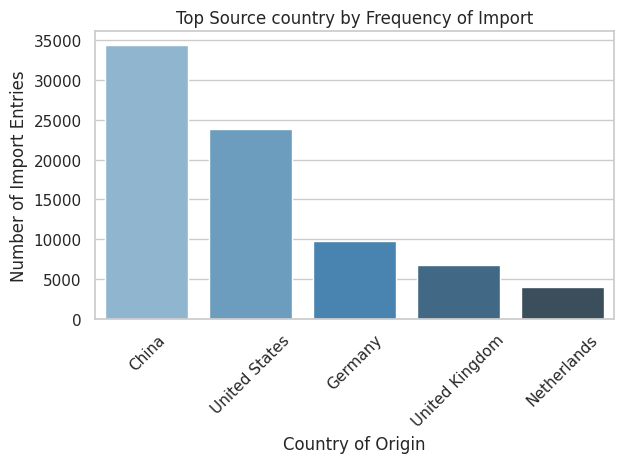

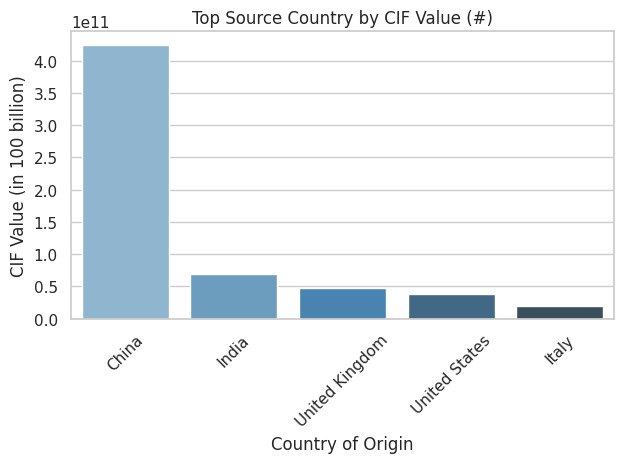

In [ ]:
# Visualize Top Countries of Origin

# --- Top Countries by Frequency
top_origin_freq = origin_freq.head(5)
sns.barplot(x='Country_of_Origin', y='count', data=top_origin_freq, palette='Blues_d', legend=False, hue='Country_of_Origin')
plt.title('Top Source country by Frequency of Import')
plt.xlabel('Country of Origin')
plt.ylabel('Number of Import Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top Countries by CIF (#) Value
top_origin_value = origin_value.head(5)
sns.barplot(x='Country_of_Origin', y='CIF_Value(N)', data=top_origin_value, hue='Country_of_Origin', palette='Blues_d')
plt.title('Top Source Country by CIF Value (#)')
plt.xlabel('Country of Origin')
plt.ylabel('CIF Value (in 100 billion)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

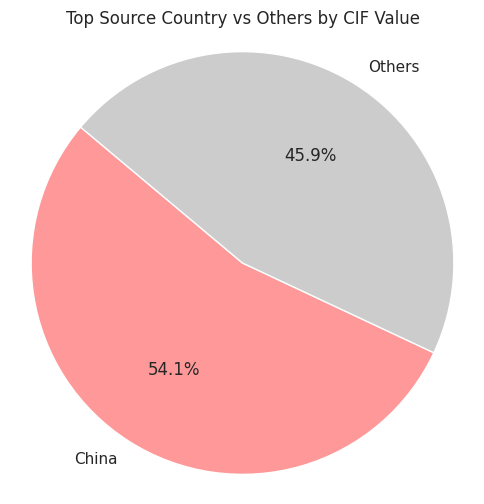

In [ ]:
# Visualize Top 1 Country Against others
top_country = origin_value.iloc[0]
others_cif = origin_value.iloc[1:]['CIF_Value(N)'].sum()

labels = [top_country['Country_of_Origin'], 'Others']
sizes = [top_country['CIF_Value(N)'], others_cif]
colors = ['#ff9999', '#cccccc']

# Step 4: Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top Source Country vs Others by CIF Value')
plt.axis('equal')
plt.show()

### **3.4 Trends in Import Volume/Value Over Time**

In [ ]:
month_order = list(calendar.month_name)[1:]

# Convert Month column to ordered categorical type
data['Month'] = pd.Categorical(data['Month'], categories=month_order, ordered=True)

monthly_trend = data.groupby('Month')[['CIF_Value(N)', 'FOB_Value(N)']].sum().reset_index()

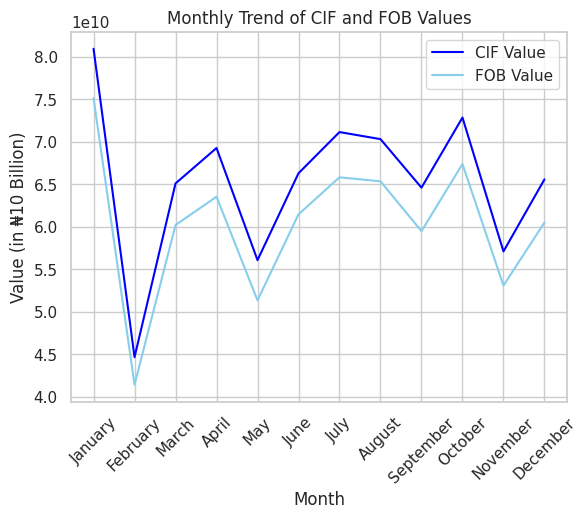

In [ ]:
# Visualize monthly trend of import value

sns.lineplot(data=monthly_trend, x='Month', y='CIF_Value(N)', label='CIF Value', color='blue')
sns.lineplot(data=monthly_trend, x='Month', y='FOB_Value(N)', label='FOB Value', color='skyblue')
plt.title("Monthly Trend of CIF and FOB Values")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("Value (in ₦10 Billion)")
plt.legend()
plt.show()

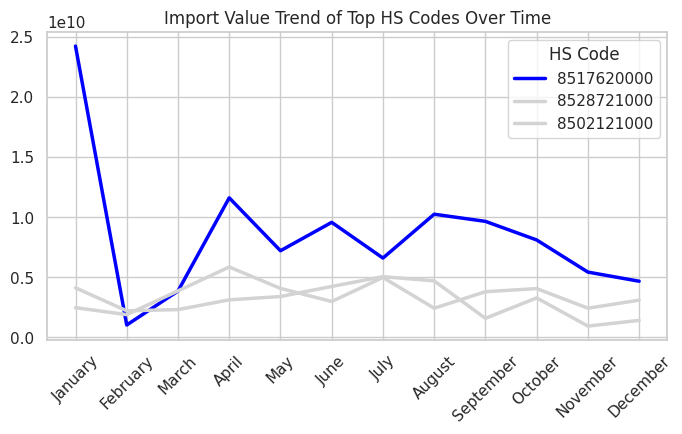

In [ ]:
# Monthly Import Trend of Top 3 HS Codes

top3_hs_value = hs_value.head(3)['HS_Code']

# Filter for only top HS Codes
top_data = data[data['HS_Code'].isin(top3_hs_value)]

# Group by Month and HS Code
trend_data = top_data.groupby(['Month', 'HS_Code'])['CIF_Value(N)'].sum().reset_index()

top_1 = top3_hs_value.iloc[0]
plt.figure(figsize=(8,4))
colors = {}
for hs in top3_hs_value:
    if hs == top_1:
        colors[hs] = 'blue'
    else:
        colors[hs] = 'lightgray'

for hs_code in top3_hs_value:
    subset = trend_data[trend_data['HS_Code'] == hs_code]
    plt.plot(subset['Month'].astype(str), subset['CIF_Value(N)'], label=hs_code, color=colors[hs_code], linewidth=2.5)

plt.title('Import Value Trend of Top HS Codes Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='HS Code')
plt.show()

### **3.5 Countries Dominating Supply for Critical/Top HS Codes**

In [ ]:
# Identify top 5 HS Code by import value
top5_hs_value = hs_value.head(5)['HS_Code']

critical_hs = data[data['HS_Code'].isin(top5_hs_value)]

# Group by HS Code and Country_of_Supply
critical_supply = critical_hs.groupby(['HS_Code', 'Country_of_Supply'])['CIF_Value(N)'].sum().sort_values(ascending=False).reset_index()

# calculate total CIF per HS_Code
total_cif_per_code = critical_supply.groupby('HS_Code')['CIF_Value(N)'].sum()

# match each row's HS_Code to its total
critical_supply['%_of_Total_CIF'] = critical_supply.apply(
    lambda row: (row['CIF_Value(N)'] / total_cif_per_code[row['HS_Code']] * 100).round(2),
    axis=1
)

# View top countries per HS Code
for hs in top5_hs_value:
    print(f"\nTop Countries Supplying HS Code {hs}:")
    display(critical_supply[critical_supply['HS_Code'] == hs].head(5))


Top Countries Supplying HS Code 8517620000:


,HS_Code,Country_of_Supply,CIF_Value(N),%_of_Total_CIF
0,8517620000,China,66487351119,65.01
4,8517620000,Netherlands,13995227851,13.68
7,8517620000,Sweden,10903419584,10.66
15,8517620000,United Arab Emirates,2184041007,2.14
18,8517620000,France,1562393517,1.53



Top Countries Supplying HS Code 8528721000:


,HS_Code,Country_of_Supply,CIF_Value(N),%_of_Total_CIF
1,8528721000,China,30145666839,71.84
6,8528721000,South Korea,11545614271,27.51
58,8528721000,United Arab Emirates,135226911,0.32
60,8528721000,Indonesia,111917430,0.27
93,8528721000,"Taiwan, Province of China",16148247,0.04



Top Countries Supplying HS Code 8502121000:


,HS_Code,Country_of_Supply,CIF_Value(N),%_of_Total_CIF
2,8502121000,United Kingdom,17353319243,47.68
5,8502121000,China,13275236257,36.48
14,8502121000,India,2311251562,6.35
22,8502121000,Lebanon,1022615313,2.81
28,8502121000,Belgium,741094510,2.04



Top Countries Supplying HS Code 8504409000:


,HS_Code,Country_of_Supply,CIF_Value(N),%_of_Total_CIF
3,8504409000,China,15185385531,45.85
9,8504409000,India,6682596495,20.18
13,8504409000,Poland,2786203415,8.41
17,8504409000,Malaysia,1610277345,4.86
23,8504409000,Netherlands,897125016,2.71



Top Countries Supplying HS Code 8502392000:


,HS_Code,Country_of_Supply,CIF_Value(N),%_of_Total_CIF
8,8502392000,Belgium,6802876274,25.79
10,8502392000,Saudi Arabia,5922904443,22.45
11,8502392000,United Kingdom,3943426213,14.95
12,8502392000,United States,3529512152,13.38
16,8502392000,China,1962923999,7.44


<Figure size 800x500 with 0 Axes>

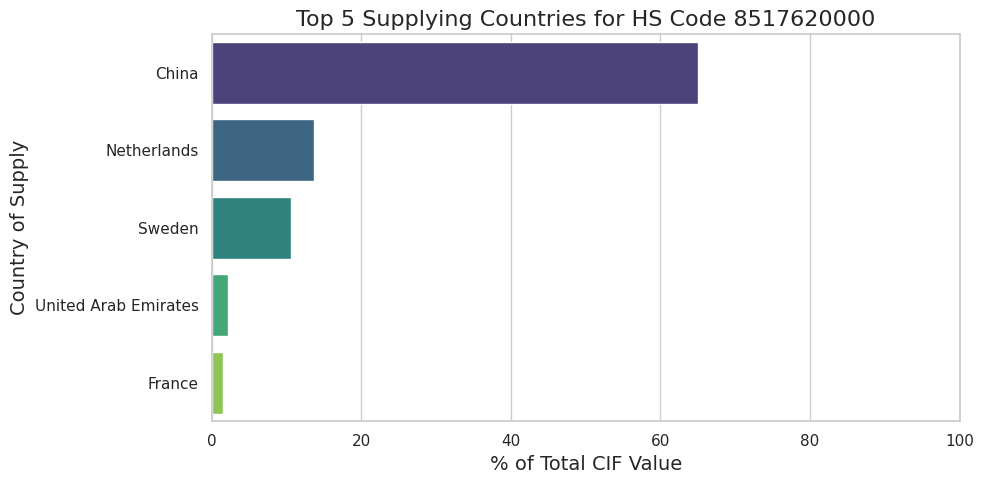

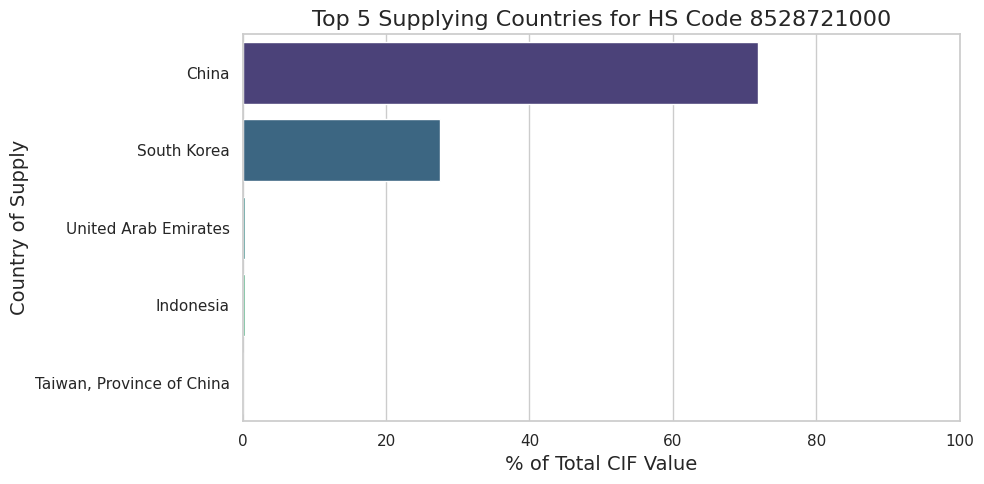

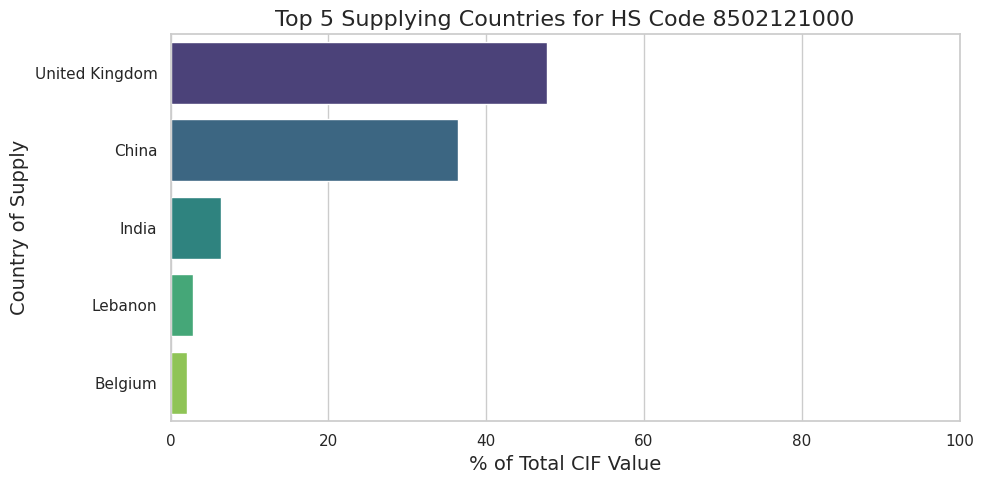

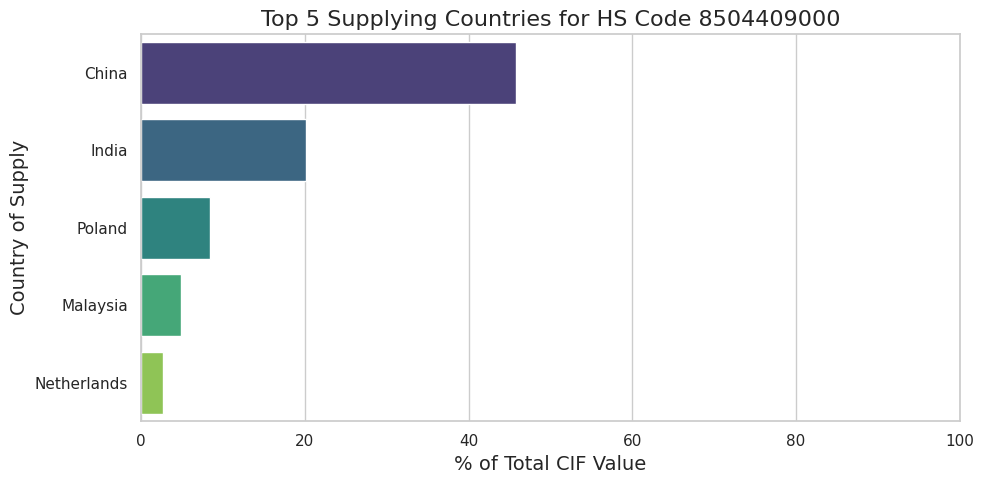

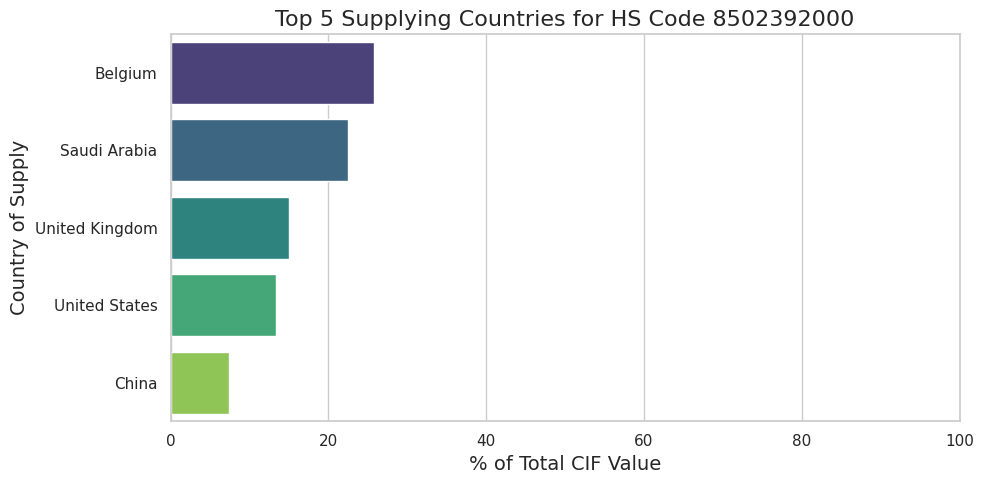

In [ ]:
# Visualize Top countries supplying Critical HS Codes

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot for each HS_Code
for hs in top5_hs_value:
    subset = critical_supply[critical_supply['HS_Code'] == hs].sort_values('%_of_Total_CIF', ascending=False).head(5)

    plt.figure(figsize=(10,5))
    sns.barplot(
        x='%_of_Total_CIF',
        y='Country_of_Supply',
        data=subset,
        palette='viridis',
        hue='Country_of_Supply'
    )

    plt.title(f"Top 5 Supplying Countries for HS Code {hs}", fontsize=16)
    plt.xlabel("% of Total CIF Value", fontsize=14)
    plt.ylabel("Country of Supply", fontsize=14)
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

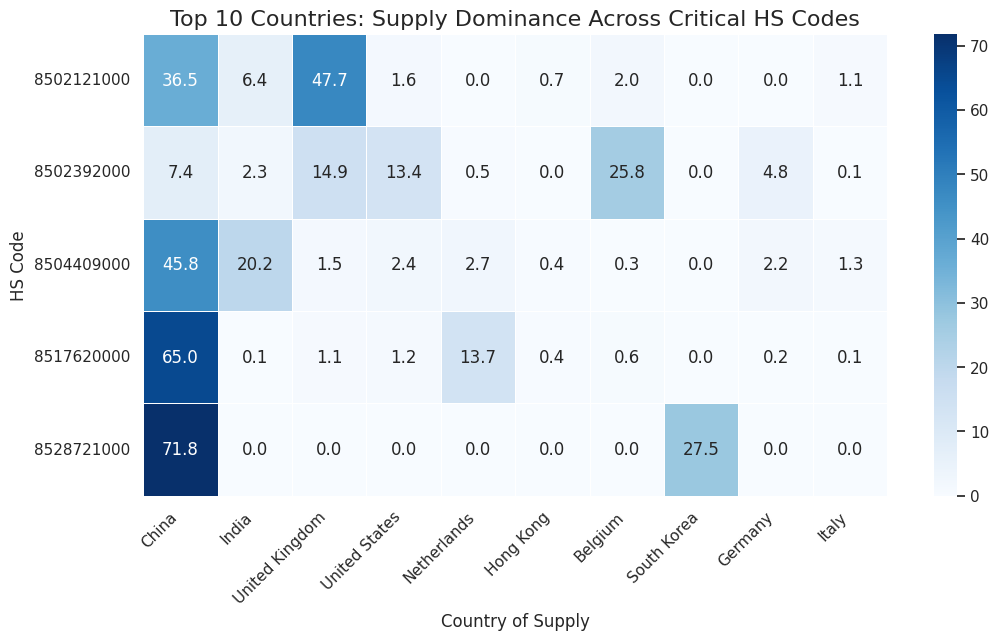

In [ ]:
pivot_table = critical_hs.pivot_table(
    index='HS_Code',
    columns='Country_of_Supply',
    values='CIF_Value(N)',
    aggfunc='sum',
    fill_value=0
)

# Normalize the pivot table row-wise
pivot_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Select top 10 countries overall
top_countries = data.groupby('Country_of_Supply')['CIF_Value(N)'].sum().sort_values(ascending=False).head(10).index

# Filter pivot table
pivot_filtered = pivot_normalized[top_countries]

# Plot filtered heatmap
plt.figure(figsize=(12,6))
sns.heatmap(pivot_filtered, cmap="Blues", annot=True, fmt=".1f", linewidths=.5)

plt.title('Top 10 Countries: Supply Dominance Across Critical HS Codes', fontsize=16)
plt.xlabel('Country of Supply')
plt.ylabel('HS Code')
plt.xticks(rotation=45, ha='right')
plt.show()

### **3.6 Conclusion: Strategic Import Dependency**

#### **Key Insights**
- **Product Concentration**:  
  - Top 5 HS codes ~ 30% of total import value  
  - Peak items:  
    - `8517120000` (Mobile phones) - **Most frequent import**  
    - `8517620000` (Data transmission machines) - **Highest value (₦102.28B, 13.05%)**  

- **Geographic Risks**:  
  - **China dominates**: 54% of origin & 50% of supply value  
  - Limited diversification (Next-largest origin: India 9%, UK 6%)  

- **Seasonality**:
  - **January peak**: Highest import volumes
  - **February drop**: Sharp decline following January surge (seasonal pattern)
  - **Mid-year dips**: Notable reductions in **May** and **November** suggesting demand volatility
  - **Q4 fluctuation**: Moderate recovery after November dip

#### **Recommendation**
1. **Diversify Sources:**
  - Implement **China+1** sourcing strategy for telecom/electronics to reduce geopolitical risk

2. **Boost Local Capacity**:  
   - Target `8517620000` for SKD assembly tax incentives  

3. **Dynamic Trade Policies**:  
   - Tariff bands for over-concentrated HS codes  
   - Real-time Herfindahl-Hirschman Index (HHI) dashboard for HS code concentration.

## **4. Taxation Optimization & Revenue Leakage**

### **4.1 Key Metric: Total Tax Value (N)**

In [ ]:
# Calculate Total Tax Revenue
total_tax_rev = data['Total_Tax(N)'].sum()
print(f"Total Revenue From Tax: {total_tax_rev:,.2f} Naira")

Total Revenue From Tax: 100,162,982,074.00 Naira


### **4.2 Data Preparation & Tax Rate Computation**

In [ ]:
#calculate observed tax rate
data['Obs_Tax_Rate(%)'] = ((data['Total_Tax(N)'] / data['CIF_Value(N)']) * 100).round(1)

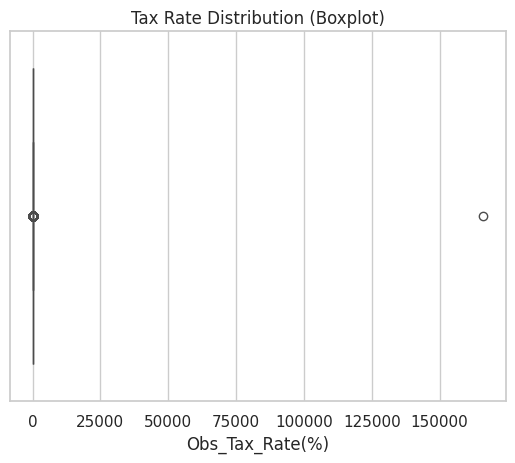

In [ ]:
# Distribution of tax rate to check for outliers
sns.boxplot(data=data, x='Obs_Tax_Rate(%)')
plt.title('Tax Rate Distribution (Boxplot)')
plt.show()

In [ ]:
# Check for outliers in Tax Rate column
data['Obs_Tax_Rate(%)'].quantile([0.95, 0.99, 0.999, 1])

,Obs_Tax_Rate(%)
0.950,29.0
0.990,44.7
0.999,70.8
1.000,166163.1


count    110366.000000
mean         17.138719
std           9.676227
min           0.000000
25%          12.000000
50%          17.400000
75%          28.700000
max          71.500000
Name: Obs_Tax_Rate(%), dtype: float64 



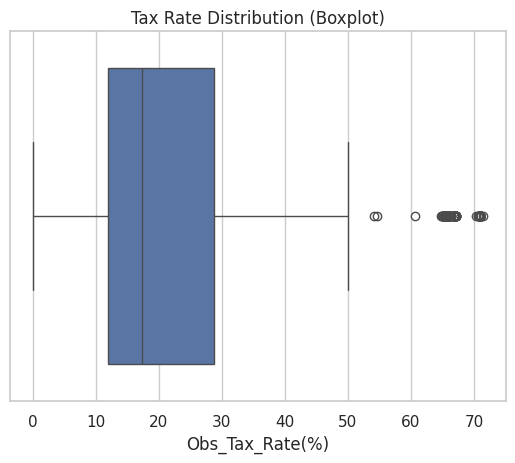

In [ ]:
# Remove Extreme Outliers
data = data[data['Obs_Tax_Rate(%)'] <= 100]

print(data['Obs_Tax_Rate(%)'].describe(), '\n')

# Distribution of tax rate
sns.boxplot(data=data, x='Obs_Tax_Rate(%)')
plt.title('Tax Rate Distribution (Boxplot)')
plt.show()

In [ ]:
# load external datset containing Nigeria Custom Services (NCS) approved Rate
tax_data = pd.read_excel('/content/drive/MyDrive/ZTH_Hackathon/cet_tariff.xlsx')
tax_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HS_Code       350 non-null    int64  
 1   Exp_Tax_Rate  350 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.6 KB


In [ ]:
# Ensuring both datasets have HS_Code as string
tax_data['HS_Code'] = tax_data['HS_Code'].astype(str)

# rename expected rax rate
tax_data = tax_data.rename(columns={'Exp_Tax_Rate': 'Exp_Tax_Rate(%)'})


# view dataset
tax_data.head()

,HS_Code,Exp_Tax_Rate(%)
0,8541420000,0.0
1,8541430000,0.0
2,8535900000,10.0
3,8517130000,22.5
4,8519811000,32.5


In [ ]:
# merge both datasets on HS_Code
merged_data = data.merge(tax_data, on='HS_Code', how='left')
print(merged_data.shape)
merged_data.head()

(110366, 15)


,Custom_Office,Reg_Number,Reg_Date,Importer,Item_Nbr,HS_Code,HS_Description,FOB_Value(N),CIF_Value(N),Total_Tax(N),Country_of_Origin,Country_of_Supply,Month,Obs_Tax_Rate(%),Exp_Tax_Rate(%)
0,PORT HARCOURT(3) ONNE,C33563,2019-09-03,0. C. CHRIS & CO,1\2,8513100000,Lamps Designed To Function By Their Own Source...,880200,1069001,308512,China,China,September,28.9,27.5
1,TIN CAN ISLAND,C102199,2019-08-19,08 EXPRESS SERVICES,4\4,8528739000,"Reception Apparatus For Television, Monochrome...",652000,652000,189374,United States,United States,August,29.0,42.5
2,TIN CAN ISLAND,C90075,2019-07-24,08 EXPRESS SERVICES,4\4,8528739000,"Reception Apparatus For Television, Monochrome...",489000,489000,142031,United States,United States,July,29.0,42.5
3,TIN CAN ISLAND,C33952,2019-03-25,08 EXPRESS SERVICES,4\4,8509800000,Other Electromechanical Domestic Appliance,341524,341524,99198,United Kingdom,United Kingdom,March,29.0,27.5
4,APAPA PORT,C11025,2019-02-18,08 EXPRESS SERVICES,4\4,8509800000,Other Electromechanical Domestic Appliance,200001,200001,58095,United Kingdom,United Kingdom,February,29.0,27.5


In [ ]:
merged_data.isnull().sum()

,0
Custom_Office,0
Reg_Number,0
Reg_Date,0
Importer,0
Item_Nbr,0
HS_Code,0
HS_Description,0
FOB_Value(N),0
CIF_Value(N),0
Total_Tax(N),0


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110366 entries, 0 to 110365
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Custom_Office      110366 non-null  object        
 1   Reg_Number         110366 non-null  object        
 2   Reg_Date           110366 non-null  datetime64[ns]
 3   Importer           110366 non-null  object        
 4   Item_Nbr           110366 non-null  object        
 5   HS_Code            110366 non-null  object        
 6   HS_Description     110366 non-null  object        
 7   FOB_Value(N)       110366 non-null  int64         
 8   CIF_Value(N)       110366 non-null  int64         
 9   Total_Tax(N)       110366 non-null  int64         
 10  Country_of_Origin  110366 non-null  object        
 11  Country_of_Supply  110366 non-null  object        
 12  Month              110366 non-null  category      
 13  Obs_Tax_Rate(%)    110366 non-null  float64 

In [ ]:
# Calculate Expected Tax Amount
merged_data['Exp_Total_Tax(N)'] = ((merged_data['CIF_Value(N)'] * merged_data['Exp_Tax_Rate(%)']) / 100).astype(int)

# Calculate Tax Gap
merged_data['Tax_Gap(N)'] = ((merged_data['Exp_Total_Tax(N)'] - merged_data['Total_Tax(N)']))

# Difference in Rate
merged_data['Tax_Gap(%)'] = (merged_data['Exp_Tax_Rate(%)'] - merged_data['Obs_Tax_Rate(%)']).round(1)

# print all computed values
print('Total Expected Tax (N):', "{:,.0f}".format(merged_data['Exp_Total_Tax(N)'].sum()))
print('Total Observed Tax (N):', "{:,.0f}".format(merged_data['Total_Tax(N)'].sum()))
print('Total Tax Gap(N):', "{:,.0f}".format(merged_data['Tax_Gap(N)'].sum()))
print('Average Observed Tax Rate(%):', "{:.1f}".format(merged_data['Obs_Tax_Rate(%)'].mean()))
print('Average Expected Tax Rate(%):', "{:.1f}".format(merged_data['Exp_Tax_Rate(%)'].mean()))
print('Total Tax Gap:', "{:,.1f}".format(merged_data['Tax_Gap(N)'].sum()))

Total Expected Tax (N): 109,024,549,339
Total Observed Tax (N): 100,162,432,065
Total Tax Gap(N): 8,862,117,274
Average Observed Tax Rate(%): 17.1
Average Expected Tax Rate(%): 17.6
Total Tax Gap: 8,862,117,274.0


### **4.3 CIF vs. Tax Collected Across Customs Offices and Importers**

#### **4.3.1 By Custom Office**

In [ ]:
# CIF vs Tax: Group by Custom Office
customs_tax = merged_data.groupby('Custom_Office').agg({
    'CIF_Value(N)': 'sum',
    'Total_Tax(N)': 'sum',
    'Exp_Total_Tax(N)': 'sum'
})


# Calculate tax rates and gaps by Custom Office
customs_tax['Obs_Tax_Rate(%)'] = (customs_tax['Total_Tax(N)'] / customs_tax['CIF_Value(N)']) * 100
customs_tax['Exp_Tax_Rate(%)'] = customs_tax['Exp_Total_Tax(N)'] / customs_tax['CIF_Value(N)'] * 100
customs_tax['Tax_Gap(%)'] = customs_tax['Exp_Tax_Rate(%)'] - customs_tax['Obs_Tax_Rate(%)']
customs_tax['Tax_Gap(N)'] = customs_tax['Exp_Total_Tax(N)'] - customs_tax['Total_Tax(N)']
customs_tax.sort_values(by='Tax_Gap(N)', ascending=False, inplace=True)
print('Custom Office Comparison \n')
customs_tax.reset_index()

Custom Office Comparison 



,Custom_Office,CIF_Value(N),Total_Tax(N),Exp_Total_Tax(N),Obs_Tax_Rate(%),Exp_Tax_Rate(%),Tax_Gap(%),Tax_Gap(N)
0,TIN CAN ISLAND,148431090541,20685755627,23109488464,13.936269,15.569170,1.632901,2423732837
1,APAPA PORT,304605868507,38002217935,40279439429,12.475865,13.223461,0.747596,2277221494
2,TINCAN 2,44538260000,5044545477,6808056084,11.326319,15.285860,3.959541,1763510607
3,PORT HARCOURT(3) ONNE,44929471514,4733552767,6294491500,10.535518,14.009716,3.474198,1560938733
4,ABUJA AIRPORT,3514813988,192224160,600465147,5.468971,17.083839,11.614867,408240987
5,WARRI PORT,12165899024,574793525,969730931,4.724628,7.970894,3.246266,394937406
6,PTML CUSTOMS OFFICE,26870381479,3784952821,4007355444,14.085966,14.913653,0.827687,222402623
7,OIL AND GAS TERMINAL,4111224810,624871243,728021514,15.199150,17.708142,2.508991,103150271
8,MUHAMMED MURTALA CARGO,139653556355,19756245370,19853896709,14.146611,14.216535,0.069924,97651339
9,PORT HARCOURT(2) AIRPORT,12899368293,1853879725,1887955493,14.371864,14.636031,0.264166,34075768


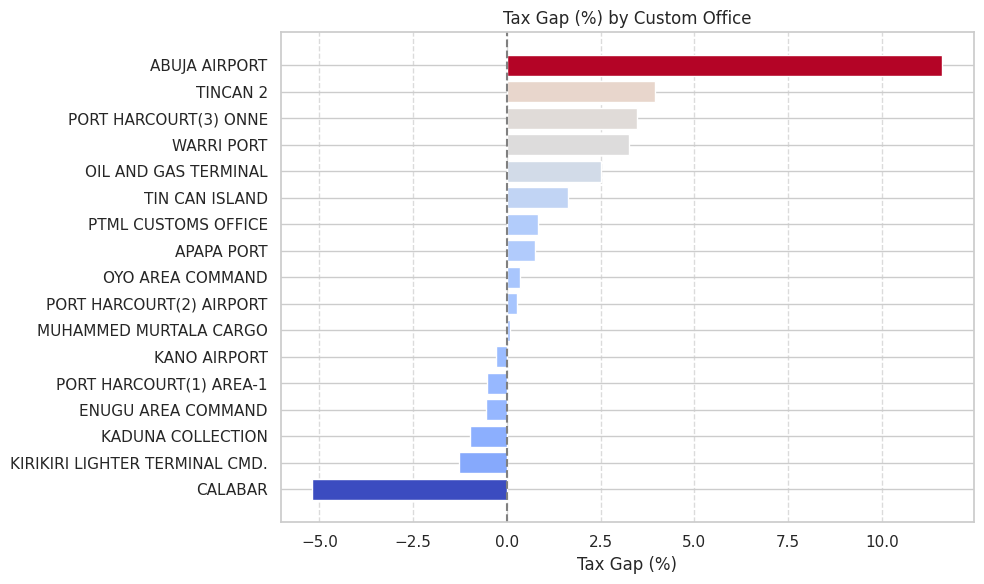

In [ ]:
# Visualize tax rates and gaps(%) by Custom Office
customs_tax_sorted = customs_tax.sort_values(by='Tax_Gap(%)', ascending=False)

# Normalize and set colour
norm = mcolors.Normalize(vmin=customs_tax_sorted['Tax_Gap(%)'].min(), vmax=customs_tax_sorted['Tax_Gap(%)'].max())
colors = cm.coolwarm(norm(customs_tax_sorted['Tax_Gap(%)'].values))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(customs_tax_sorted.index, customs_tax_sorted['Tax_Gap(%)'], color=colors)
plt.xlabel('Tax Gap (%)')
plt.title('Tax Gap (%) by Custom Office')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

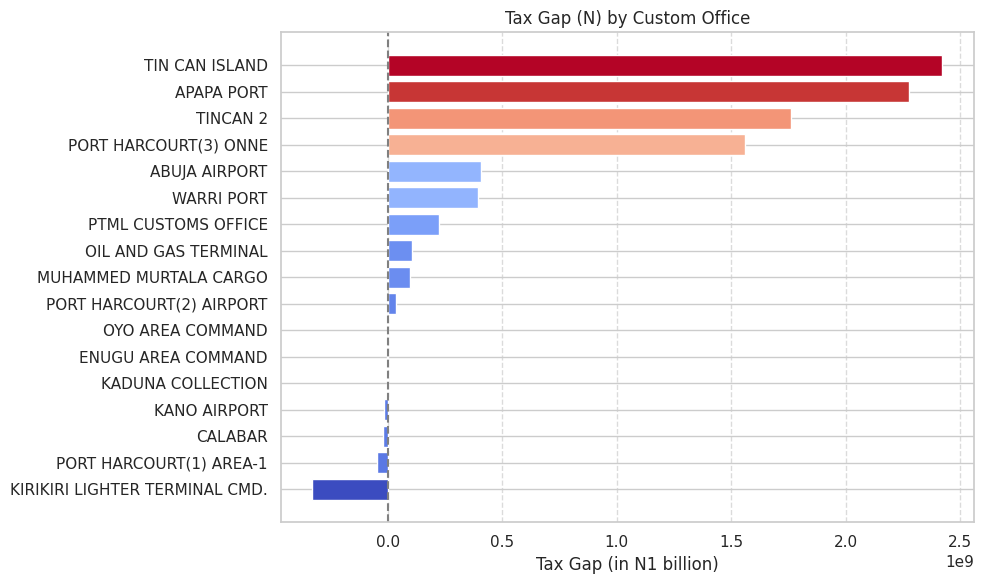

In [ ]:
# Visualize tax rates and gaps value by Custom Office
# normalize and set colour
norm = mcolors.Normalize(vmin=customs_tax['Tax_Gap(N)'].min(), vmax=customs_tax['Tax_Gap(N)'].max())
colors = cm.coolwarm(norm(customs_tax['Tax_Gap(N)'].values))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(customs_tax.index, customs_tax['Tax_Gap(N)'], color=colors)
plt.xlabel('Tax Gap (in N1 billion)')
plt.title('Tax Gap (N) by Custom Office')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

#### **4.3.2 By Importer**

In [ ]:
# CIF vs Tax: Group by Importer
importer_tax = merged_data.groupby('Importer').agg({
    'CIF_Value(N)': 'sum',
    'Total_Tax(N)': 'sum',
    'Exp_Total_Tax(N)': 'sum',
}).reset_index()


# Calculate tax rates and gaps for each Importer
importer_tax['Obs_Tax_Rate(%)'] = (importer_tax['Total_Tax(N)'] / importer_tax['CIF_Value(N)']) * 100
importer_tax['Exp_Tax_Rate(%)'] = importer_tax['Exp_Total_Tax(N)'] / importer_tax['CIF_Value(N)'] * 100
importer_tax['Tax_Gap(%)'] = importer_tax['Exp_Tax_Rate(%)'] - importer_tax['Obs_Tax_Rate(%)']
importer_tax['Tax_Gap(N)'] = importer_tax['Exp_Total_Tax(N)'] - importer_tax['Total_Tax(N)']

#sort importer by those with highest tax gaps
print('Top 10 Importers by Tax Gap (N)\n')
importer_tax.sort_values(by='Tax_Gap(N)', ascending=False).head(10)

Top 10 Importers by Tax Gap (N)



,Importer,CIF_Value(N),Total_Tax(N),Exp_Total_Tax(N),Obs_Tax_Rate(%),Exp_Tax_Rate(%),Tax_Gap(%),Tax_Gap(N)
2336,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,28892056425,3118935018,5119328094,10.795130,17.718808,6.923678,2000393076
6268,MULTI-CHOICE NIGERIA LIMITED,17260472048,4938158154,6929236328,28.609636,40.145115,11.535479,1991078174
4536,INDORAMA ELEME FERTILIZER & CHEMICALS LIMITED,10747088480,304788078,1924695778,2.836006,17.908997,15.072991,1619907700
2329,DANGOTE CEMENT PLC,11641746391,368621654,1961528828,3.166378,16.849094,13.682717,1592907174
1642,CCETC OSSIOMO POWER COMPANY LIMITED EDO,11560932097,206512616,1007193262,1.786297,8.712042,6.925745,800680646
6497,NIGER DELTA POWER HOLDING COMPANY LTD,6913992026,170258330,792908531,2.462518,11.468172,9.005654,622650201
8770,STERLING & WILSON NIGERIA LIMITED,2996962959,102025599,561270707,3.404300,18.727983,15.323683,459245108
3613,FOUANI NIGERIA LIMITED,45754060112,6662698522,6997354221,14.561983,15.293406,0.731423,334655699
9208,TRANSMISSION COMPANY OF NIG.(TCN) MAITAMA,3378480606,156846433,466779349,4.642514,13.816251,9.173737,309932916
1462,BRITISH HIGH COMMISSION,1887393105,0,281755300,0.000000,14.928279,14.928279,281755300


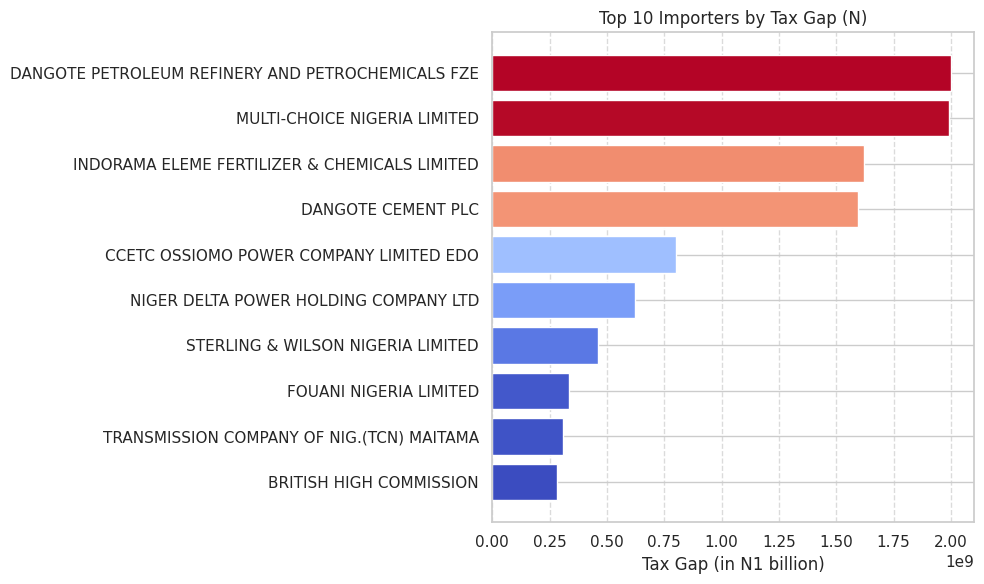

In [ ]:
# Visualize tax rates and gap value by Importer
top_importers_n = importer_tax.sort_values(by='Tax_Gap(N)', ascending=False).head(10)

# Normalize colors for Naira gap
norm_n = mcolors.Normalize(vmin=top_importers_n['Tax_Gap(N)'].min(), vmax=top_importers_n['Tax_Gap(N)'].max())
colors_n = cm.coolwarm(norm_n(top_importers_n['Tax_Gap(N)'].values))

plt.figure(figsize=(10, 6))

# Plot: Tax Gap (₦)
plt.barh(top_importers_n['Importer'], top_importers_n['Tax_Gap(N)'], color=colors_n)
plt.xlabel('Tax Gap (in N1 billion)')
plt.title('Top 10 Importers by Tax Gap (N)')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **4.4 Estimated Tax Gap by HS Code**

In [ ]:
# Group by HS Code
tax_gap_hs = merged_data.groupby(['HS_Code', 'HS_Description']).agg({
    'CIF_Value(N)': 'sum',
    'Exp_Total_Tax(N)': 'sum',
    'Total_Tax(N)': 'sum',
}).reset_index()

tax_gap_hs['Obs_Tax_Rate(%)'] = (tax_gap_hs['Total_Tax(N)'] / tax_gap_hs['CIF_Value(N)']) * 100
tax_gap_hs['Exp_Tax_Rate(%)'] = (tax_gap_hs['Exp_Total_Tax(N)'] / tax_gap_hs['CIF_Value(N)']) * 100
tax_gap_hs['Tax_Gap(%)'] = tax_gap_hs['Exp_Tax_Rate(%)'] - tax_gap_hs['Obs_Tax_Rate(%)']
tax_gap_hs['Tax_Gap(N)'] = tax_gap_hs['Exp_Total_Tax(N)'] - tax_gap_hs['Total_Tax(N)']

# View top HS Codes with highest gaps
print('HS Codes with the highest tax gaps \n')
tax_gap_hs.sort_values('Tax_Gap(N)', ascending=False).head(10)

HS Codes with the highest tax gaps 



,HS_Code,HS_Description,CIF_Value(N),Exp_Total_Tax(N),Total_Tax(N),Obs_Tax_Rate(%),Exp_Tax_Rate(%),Tax_Gap(%),Tax_Gap(N)
190,8528719000,"Reception Apparatus For Television, With No Vi...",16067707912,6828775141,4657944123,28.989475,42.499996,13.510521,2170831018
290,8544600000,"Other Electric Conductors, For A Voltage Excee...",18173775432,3180410579,1106370987,6.087733,17.499999,11.412266,2074039592
42,8504230000,"Liquid Dielectric Transformers, Having A Power...",8414210494,1051776271,184059829,2.187488,12.500000,10.312512,867716442
288,8544491000,"Almenec Insulated Cables, Metallic Part Made O...",5685176450,994905807,157604762,2.772205,17.499999,14.727793,837301045
236,8536900000,Other Apparatus Of Heading 85.36 Not Specified,5939955765,1633487084,940024396,15.825444,27.499987,11.674543,693462688
237,8537100000,"Boards, Panels, Consoles For Electric Control/...",22859138372,2857390863,2172663173,9.504572,12.499994,2.995422,684727690
232,8536500000,Other Electrical Switches,5049953736,1388735860,721246255,14.282235,27.499972,13.217737,667489605
135,8517700000,Parts Of Article Of Heading 8517,20756282745,2075627026,1409074596,6.788665,9.999994,3.211329,666552430
286,8544300000,Ignition Wiring Sets And Other Wiring Sets Of ...,2280459641,627126301,65971321,2.892896,27.499996,24.607100,561154980
289,8544499000,"Other Electric Conductors, For A Voltage Not E...",14104264697,3878672246,3419802485,24.246585,27.499996,3.253411,458869761


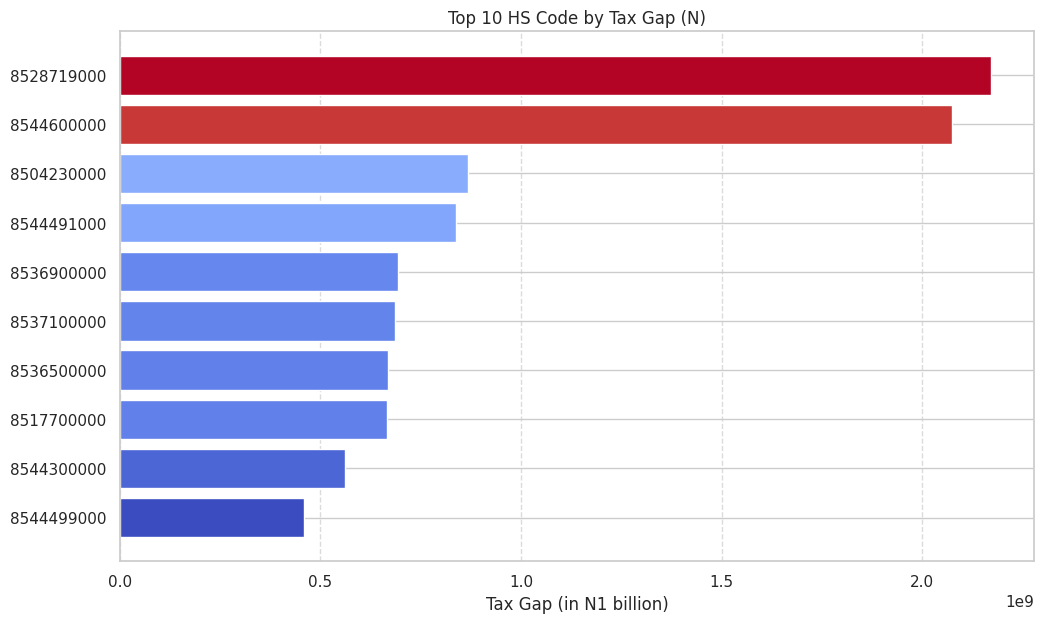

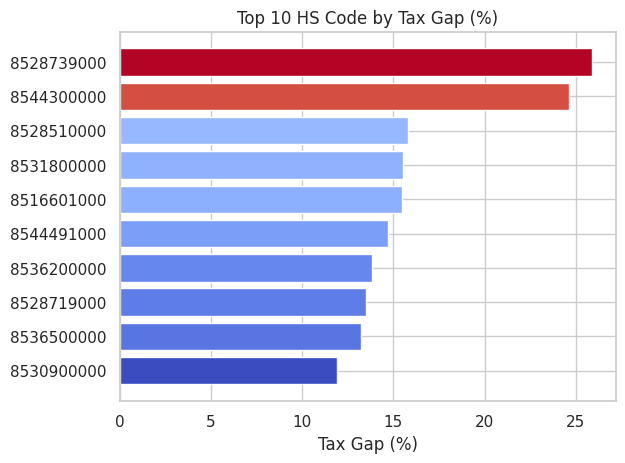

In [ ]:
# Visualize HS Code with high tax gap
# Sort by Tax Gap (Naira) and select top 10
tax_gap_hs_n = tax_gap_hs.sort_values(by='Tax_Gap(N)', ascending=False).head(10)

# Normalize colors for Naira gap
norm_n = mcolors.Normalize(vmin=tax_gap_hs_n['Tax_Gap(N)'].min(), vmax=tax_gap_hs_n['Tax_Gap(N)'].max())
colors_n = cm.coolwarm(norm_n(tax_gap_hs_n['Tax_Gap(N)'].values))

# Plot: Tax Gap (N)
plt.figure(figsize=(10, 6))
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.barh(tax_gap_hs_n['HS_Code'], tax_gap_hs_n['Tax_Gap(N)'], color=colors_n)
plt.xlabel('Tax Gap (in N1 billion)')
plt.title('Top 10 HS Code by Tax Gap (N)')
plt.gca().invert_yaxis()
plt.show()

# Sort by Tax Gap (%) and select top 10
tax_gap_hs_pct = tax_gap_hs.sort_values(by='Tax_Gap(%)', ascending=False).head(10)

# Normalize colors for percentage gap
norm_pct = mcolors.Normalize(vmin=tax_gap_hs_pct['Tax_Gap(%)'].min(), vmax=tax_gap_hs_pct['Tax_Gap(%)'].max())
colors_pct = cm.coolwarm(norm_pct(tax_gap_hs_pct['Tax_Gap(%)'].values))

# Plot: Tax Gap (%)
plt.barh(tax_gap_hs_pct['HS_Code'], tax_gap_hs_pct['Tax_Gap(%)'], color=colors_pct)
plt.xlabel('Tax Gap (%)')
plt.title('Top 10 HS Code by Tax Gap (%)')
plt.gca().invert_yaxis()
plt.show()

### **4.5 Risk Profiling: Low-Tax Goods & Importers**

In [ ]:
# Threshold: large CIF but positive Tax Gap (paid less than expected)
low_tax_data = merged_data[(merged_data['Tax_Gap(N)'] > 10000000) & (merged_data['Obs_Tax_Rate(%)'] < merged_data['Exp_Tax_Rate(%)'])]

# Group by Importer or HS Code for profiling
low_tax_profiles = low_tax_data.groupby('Importer')['Tax_Gap(N)'].sum().sort_values(ascending=False).head(10)
low_tax_profiles

,Tax_Gap(N)
Importer,
DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,2233763550
MULTI-CHOICE NIGERIA LIMITED,1981462301
INDORAMA ELEME FERTILIZER & CHEMICALS LIMITED,1505429808
DANGOTE CEMENT PLC,1489318513
CCETC OSSIOMO POWER COMPANY LIMITED EDO,768036906
NIGER DELTA POWER HOLDING COMPANY LTD,592438938
STERLING & WILSON NIGERIA LIMITED,433922874
TRANSMISSION COMPANY OF NIG.(TCN) MAITAMA,267983687
CNEEC NIGERIA LIMITED,260025454


In [ ]:
# Get list of top importers with high tax gaps
top_low_tax = low_tax_profiles.index.tolist()

top_low_tax = top_low_tax[0]
# Step 2: Filter low_tax_data to just those importers
top_importers_data = low_tax_data[low_tax_data['Importer'] == top_low_tax]

# Step 3: Group by Importer and HS_Code
importer_hscode_taxgap = top_importers_data.groupby(['Importer', 'HS_Code', 'HS_Description']).agg({
    'CIF_Value(N)': 'sum',
    'Total_Tax(N)': 'sum',
    'Tax_Gap(N)': 'sum'
}).sort_values('Tax_Gap(N)', ascending=False)

# View top HS codes per importer
print('HS Codes imported by Importer with the most Tax Gap(N)')
importer_hscode_taxgap.head()

HS Codes imported by Importer with the most Tax Gap(N)


CIF_Value(N)  \
Importer                                          HS_Code    HS_Description                                                     
DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE 8544600000 Other Electric Conductors, For A Voltage Exceed...    6917858889   
                                                  8544491000 Almenec Insulated Cables, Metallic Part Made Of...    4748525399   
                                                  8536900000 Other Apparatus Of Heading 85.36 Not Specified        1787784000   
                                                  8537100000 Boards, Panels, Consoles For Electric Control/D...     151280300   

                                                                                                                 Total_Tax(N)  \
Importer                                          HS_Code    HS_Description                                                     
DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE 8544600000 Other Electric Conductors, For A Voltage Exceed...             0   
                                                  8544491000 Almenec Insulated Cables, Metallic Part Made Of...             0   
                                                  8536900000 Other Apparatus Of Heading 85.36 Not Specified         318404331   
                                                  8537100000 Boards, Panels, Consoles For Electric Control/D...             0   

                                                                                                                 Tax_Gap(N)  
Importer                                          HS_Code    HS_Description                                                  
DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE 8544600000 Other Electric Conductors, For A Voltage Exceed...  1210625303  
                                                  8544491000 Almenec Insulated Cables, Metallic Part Made Of...   830991941  
                                                  8536900000 Other Apparatus Of Heading 85.36 Not Specified       173236269  
                                                  8537100000 Boards, Panels, Consoles For Electric Control/D...    18910037

In [ ]:
# Threshold: large CIF but positive Tax Gap (paid less than expected)
low_tax_data_p = merged_data[(merged_data['Tax_Gap(%)'] > 30) & (merged_data['Obs_Tax_Rate(%)'] < merged_data['Exp_Tax_Rate(%)'])]

# Group by Importer or HS Code for profiling
low_tax_profiles_p = low_tax_data_p.groupby('Importer')['Tax_Gap(%)'].mean().sort_values(ascending=False).head(5)
low_tax_profiles_p

,Tax_Gap(%)
Importer,
UN WORLD FOOD PROGRAMME,62.500
BRITISH HIGH COMMISSION,51.875
BONNIM.SUNDAY MR.,42.500
BELLO OMOLARA ADUKE.,42.500
ALAOMA ONWUMERE OHO,42.500


### **4.6 Anomaly Detection: Identifying Potential Under-Declarations and Tax Evasion**

#### **4.6.1 Tax Gap Distribution**

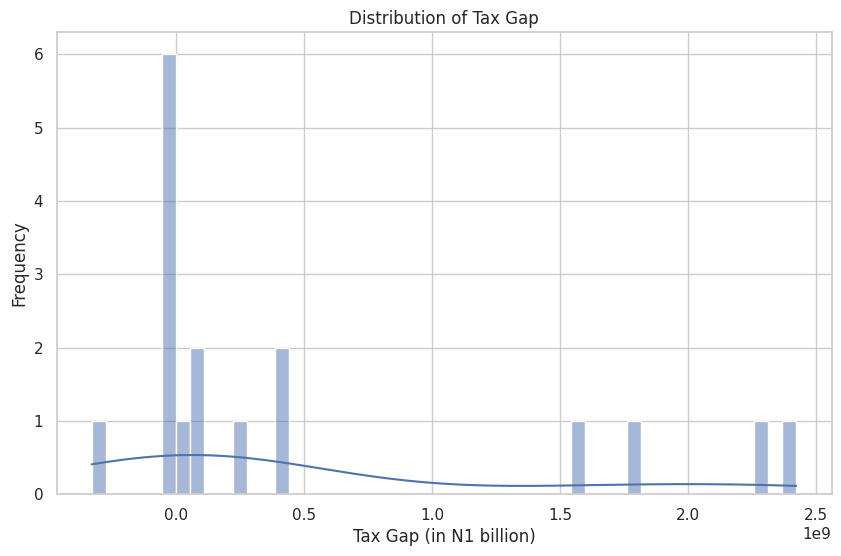

In [ ]:
# Check distribution of tax gap
plt.figure(figsize=(10,6))
sns.histplot(data=customs_tax, x='Tax_Gap(N)', bins=50, kde=True)
plt.title('Distribution of Tax Gap')
plt.xlabel('Tax Gap (in N1 billion)')
plt.ylabel('Frequency')
plt.show()

#### **4.6.2 Anomaly detection using Z-score**

In [ ]:
# Subset of relevant numeric columns
cols_to_normalize = ['CIF_Value(N)', 'Total_Tax(N)', 'Tax_Gap(N)', 'Obs_Tax_Rate(%)', 'Exp_Tax_Rate(%)']
clean_data = merged_data[cols_to_normalize].copy()

# Drop rows with missing or infinite values
clean_data = clean_data.replace([float('inf'), -float('inf')], pd.NA).dropna()

# Apply Z-score normalization
z_scores = clean_data.apply(zscore)

# flag extreme values in Tax_Gap(N)
z_scores['TaxGap_Z'] = z_scores['Tax_Gap(N)']

# Merge Z-scores back to the original data
merged_data_normalized = merged_data.loc[clean_data.index].copy()
merged_data_normalized['TaxGap_Z'] = z_scores['TaxGap_Z']

# Common threshold for outliers: |z| > 3
anomalies = merged_data_normalized[(merged_data_normalized['TaxGap_Z'].abs() > 3)]

# Review top anomalies
anomalies[['Importer', 'HS_Code', 'CIF_Value(N)', 'Tax_Gap(N)', 'Obs_Tax_Rate(%)', 'TaxGap_Z']].sort_values(by='TaxGap_Z', ascending=False).reset_index(drop=True).head(10)

,Importer,HS_Code,CIF_Value(N),Tax_Gap(N),Obs_Tax_Rate(%),TaxGap_Z
0,DANGOTE CEMENT PLC,8544200000,1601010009,416668047,1.5,109.764125
1,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,8544600000,1817555572,318072225,0.0,83.785723
2,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,8544600000,1711089605,299440680,0.0,78.876613
3,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,8544600000,1711089605,299440680,0.0,78.876613
4,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,8544491000,1596406394,279371118,0.0,73.588608
5,NIGER DELTA POWER HOLDING COMPANY LTD,8504230000,2410584206,265164260,1.5,69.845331
6,DEFENCE INTELLIGENCE AGENCY,8531800000,1305023712,228379149,0.0,60.153050
7,CCETC OSSIOMO POWER COMPANY LIMITED EDO,8544499000,1023440860,214758320,6.5,56.564182
8,FASUYI CAXTON,8528739000,460425000,195680625,0.0,51.537519
9,CNEEC NIGERIA LIMITED,8530900000,1546592151,193324018,0.0,50.916591


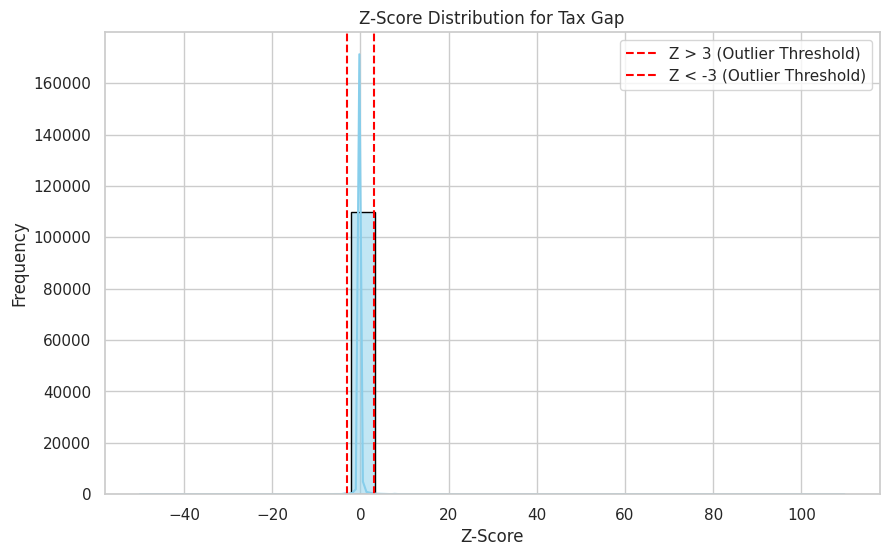

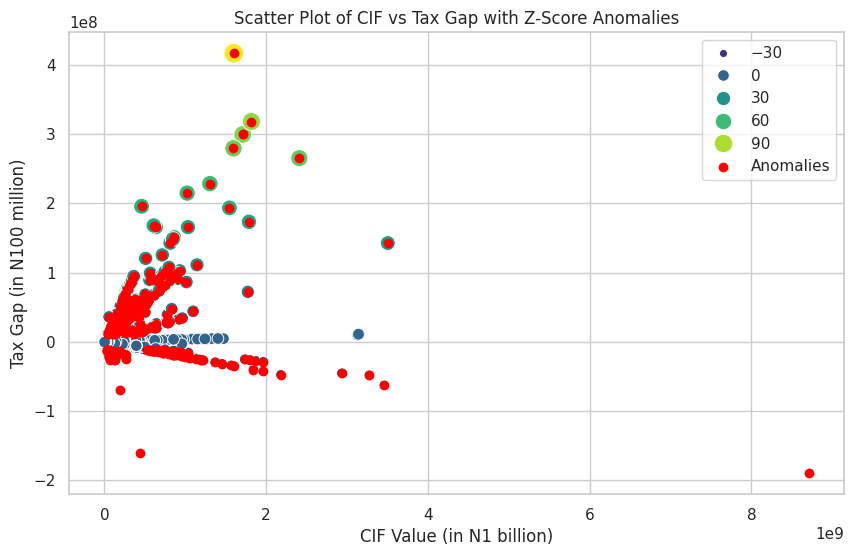

In [ ]:
# Visualize Anomalies
plt.figure(figsize=(10, 6))
sns.histplot(z_scores['TaxGap_Z'], kde=True, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=3, color='red', linestyle='--', label='Z > 3 (Outlier Threshold)')
plt.axvline(x=-3, color='red', linestyle='--', label='Z < -3 (Outlier Threshold)')
plt.title('Z-Score Distribution for Tax Gap')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_normalized, x='CIF_Value(N)', y='Tax_Gap(N)', hue='TaxGap_Z', palette='viridis', size='TaxGap_Z', sizes=(10, 200))
plt.scatter(anomalies['CIF_Value(N)'], anomalies['Tax_Gap(N)'], color='red', label='Anomalies')
plt.title('Scatter Plot of CIF vs Tax Gap with Z-Score Anomalies')
plt.xlabel('CIF Value (in N1 billion)')
plt.ylabel('Tax Gap (in N100 million)')
plt.legend()
plt.show()

#### **4.6.3 Anomaly Detection Using Isolation Forest**

In [ ]:
# Prepare data
isf_data = clean_data.copy()

# Fit Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
isf_data['Anomaly_Score'] = iso_forest.fit_predict(isf_data)

# Interpret results: -1 = anomaly, 1 = normal
isf_data['Anomaly_Label'] = isf_data['Anomaly_Score'].map({-1: 'Anomaly', 1: 'Normal'})

# Get anomaly scores (lower = more anomalous)
isf_data['Anomaly_Score_Value'] = iso_forest.decision_function(isf_data[clean_data.columns])

# Merge back to original data
merged_data_iforest = merged_data.loc[isf_data.index].copy()
merged_data_iforest['Anomaly_Label'] = isf_data['Anomaly_Label']
merged_data_iforest['Anomaly_Score_Value'] = isf_data['Anomaly_Score_Value']

# Filter and sort top anomalies
anomalies_iforest = merged_data_iforest[merged_data_iforest['Anomaly_Label'] == 'Anomaly']
anomalies_iforest = anomalies_iforest.sort_values(by='Anomaly_Score_Value')

# View top suspicious records
anomalies_iforest[['Importer', 'HS_Code', 'CIF_Value(N)', 'Tax_Gap(N)', 'Obs_Tax_Rate(%)', 'Anomaly_Score_Value']].reset_index(drop=True).head(10)

,Importer,HS_Code,CIF_Value(N),Tax_Gap(N),Obs_Tax_Rate(%),Anomaly_Score_Value
0,DANGOTE PETROLEUM REFINERY AND PETROCHEMICALS FZE,8536900000,1787784000,173236269,17.8,-0.126394
1,MOBIL PRODUCING NIGERIA UNLIMITED,8536900000,1145206588,111164465,17.8,-0.124699
2,CCETC OSSIOMO POWER COMPANY LIMITED EDO,8544499000,1023440860,214758320,6.5,-0.121882
3,SIMTECKCARD PLANT LIMITED,8523520000,141801850,-4467079,65.7,-0.115160
4,MULTI-CHOICE NIGERIA LIMITED,8528719000,748481004,101161163,29.0,-0.114602
5,MULTI-CHOICE NIGERIA LIMITED,8528719000,798620020,107536715,29.0,-0.114602
6,NIGER DELTA POWER HOLDING COMPANY LTD,8504230000,2410584206,265164260,1.5,-0.111819
7,MULTI-CHOICE NIGERIA LIMITED,8528719000,704726505,95258951,29.0,-0.111819
8,CCETC OSSIOMO POWER COMPANY LIMITED EDO,8502392000,3505450646,142561102,0.9,-0.111819
9,DANGOTE CEMENT PLC,8544200000,1601010009,416668047,1.5,-0.111263


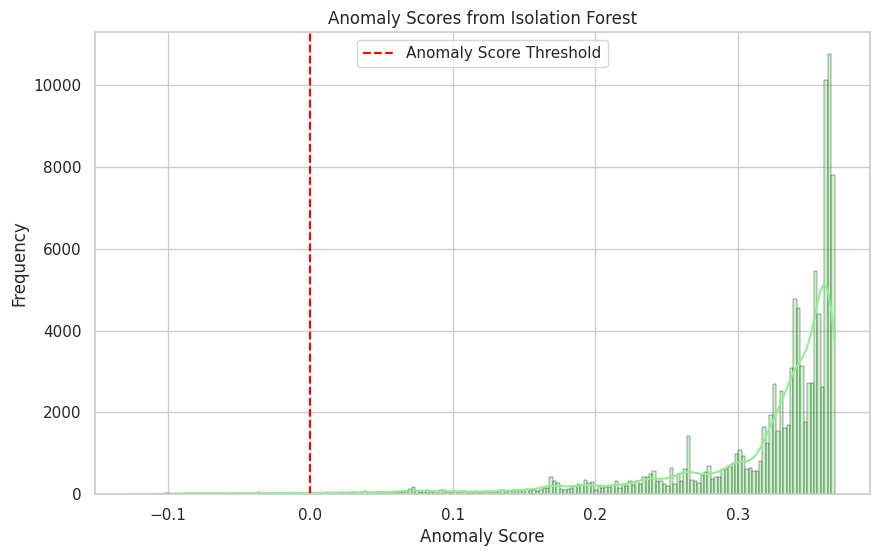

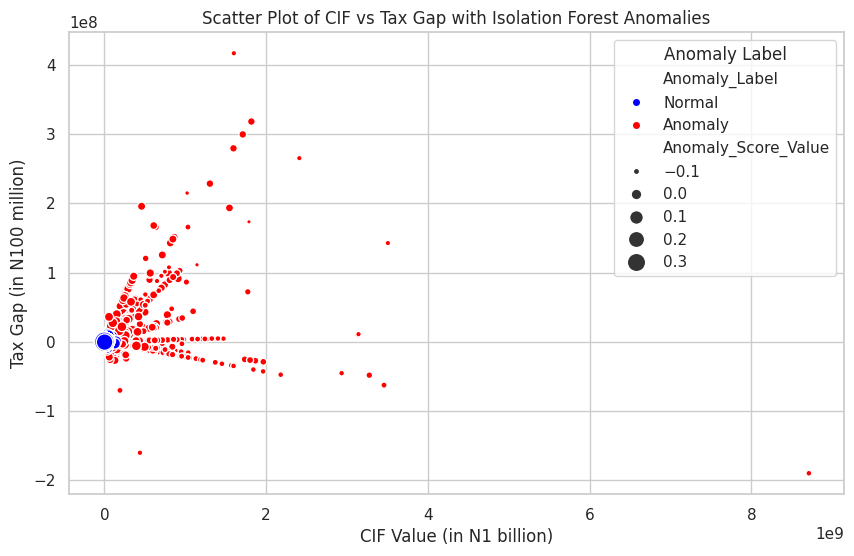

In [ ]:
# Plotting Isolation Forest anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(isf_data['Anomaly_Score_Value'], kde=True, color='lightgreen', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Anomaly Score Threshold')
plt.title('Anomaly Scores from Isolation Forest')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of anomalies using Isolation Forest results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_iforest, x='CIF_Value(N)', y='Tax_Gap(N)', hue='Anomaly_Label', palette={'Normal': 'blue', 'Anomaly': 'red'}, size='Anomaly_Score_Value', sizes=(10, 200))
plt.title('Scatter Plot of CIF vs Tax Gap with Isolation Forest Anomalies')
plt.xlabel('CIF Value (in N1 billion)')
plt.ylabel('Tax Gap (in N100 million)')
plt.legend(title='Anomaly Label')
plt.show()


### **4.7 Conclusion: Taxation Optimization & Revenue Leakage**

#### **Key Findings**
- **₦8.86B Tax Gap** (Expected: ₦109.02B vs Collected: ₦100.16B)
  - Rate shortfall: 17.1% actual vs 17.6% expected

- **Top Leakage Points**:

| Category              | Specific Cases                  | Gap Amount   |
  |-----------------------|---------------------------------|-------------|
  | **Customs Offices**   | Tin Can Island                  | ₦2.42B      |
  |                       | Apapa Port                      | ₦2.28B      |
  |                       | Tincan 2                        | ₦1.76B      |
  | **Importers**         | Dangote Petroleum Refinery      | ₦2.23B      |
  |                       | MultiChoice Nigeria             | ₦1.98B      |
  | **HS Codes**          | 8528719000 (Reception Apparatus)| ₦2.17B      |
  |                       | 8544600000 (HV Conductors)      | ₦2.07B      |

#### **Anomalies Detected**
- **Statistical Flags**:
  - Dangote Cement PLC (Z-Score/Isolation Forest outlier)
  - UN World Food Programme (>50% gap most likely due to exemptions)

#### **Recommendations**
1. **Audit Priority**:
   - Top 3 importers (₦5.71B combined gap)
   - HS 8528719000 & 8544600000 (₦4.24B gap)

2. **Port Controls**:
   - Real time CIF validation at Tin Can/Apapa

3. **Exemption Review**:
   - Verify UN/diplomatic claims

## **5. Predictive Forecasting of Import Volume & Tax Revenue**
- Time Series Forecasting with Prophet (for extrapolation)
-- We’ll use Prophet for time series forecasting since it’s user friendly and effective even with limited historical data. Prophet can handle seasonal patterns and trends, even with just one year of data.

### **5.1 Forecasting Import Value and Tax Revenue for the Next 5 Years (60 months) with Prophet**

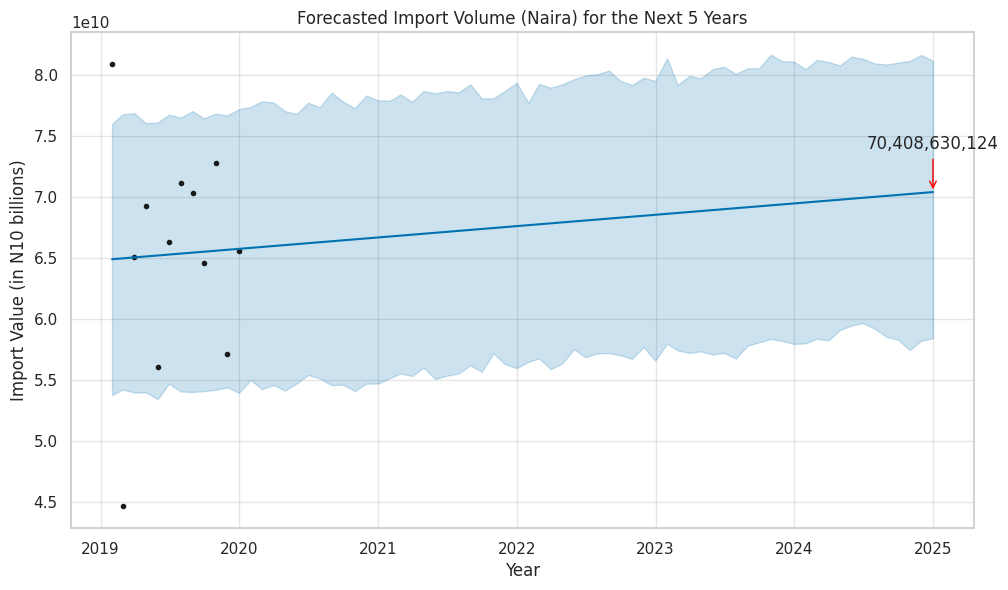

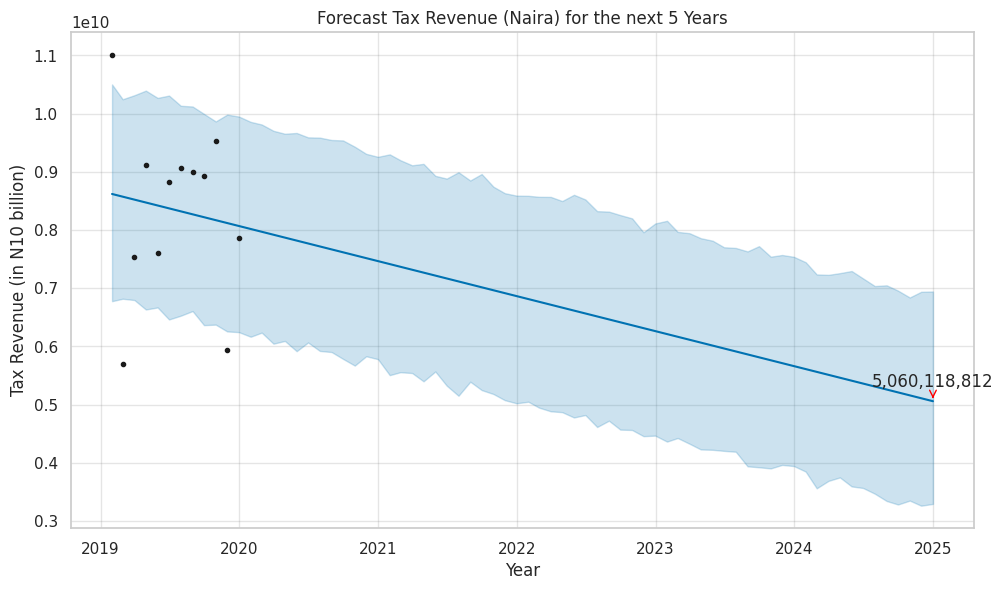

In [ ]:
# Use CIF_Value(N) as the target variable
forecast_data = merged_data[['Reg_Date', 'CIF_Value(N)', 'Total_Tax(N)', 'Exp_Total_Tax(N)']].dropna()

# Ensure Reg_Date is in datetime format
forecast_data['Reg_Date'] = pd.to_datetime(forecast_data['Reg_Date'])

# Resample to monthly data
forecast_data_monthly = forecast_data.resample('ME', on='Reg_Date').sum().reset_index()

# Forecasting Import Value for 5 years (60 months)
forecast_import = forecast_data_monthly.rename(columns={'Reg_Date': 'ds', 'CIF_Value(N)': 'y'})
import_model = Prophet()
import_model.fit(forecast_import)
future_import = import_model.make_future_dataframe(periods=60, freq='ME')
import_forecast = import_model.predict(future_import)

# Forecasting Tax Revenue for 60 months
forecast_tax = forecast_data_monthly.rename(columns={'Reg_Date': 'ds', 'Total_Tax(N)': 'y'})
tax_model = Prophet()
tax_model.fit(forecast_tax)
future_tax = tax_model.make_future_dataframe(periods=60, freq='ME')
tax_forecast = tax_model.predict(future_tax)

# Plot the import forecast
fig = import_model.plot(import_forecast)
plt.title('Forecasted Import Volume (Naira) for the Next 5 Years')
plt.xlabel("Year")
plt.ylabel("Import Value (in N10 billions)")

last_row = import_forecast.iloc[-1]
last_date = last_row['ds']
last_value = last_row['yhat']

# Annotate the last forecast value
plt.annotate(f"{last_value:,.0f}",
             xy=(last_date, last_value),
             xytext=(last_date, last_value + 0.05 * last_value),
             ha='center',
             arrowprops=dict(arrowstyle='->', color='red'))
plt.show()

# Plot tax forecast
fig2 = tax_model.plot(tax_forecast)
plt.title("Forecast Tax Revenue (Naira) for the next 5 Years")
plt.xlabel("Year")
plt.ylabel("Tax Revenue (in N10 billion)")
last_row_t = tax_forecast.iloc[-1]
last_date_t = last_row_t['ds']
last_value_t = last_row_t['yhat']

# Annotate the last forecast value
plt.annotate(f"{last_value_t:,.0f}",
             xy=(last_date_t, last_value_t),
             xytext=(last_date_t, last_value_t + 0.05 * last_value_t),
             ha='center',
             arrowprops=dict(arrowstyle='->', color='red'))

plt.show()

### **5.2 Forecasting Import Value and Tax Revenue for Top country of supply for the Next 5 Years (60 months) with Prophet**

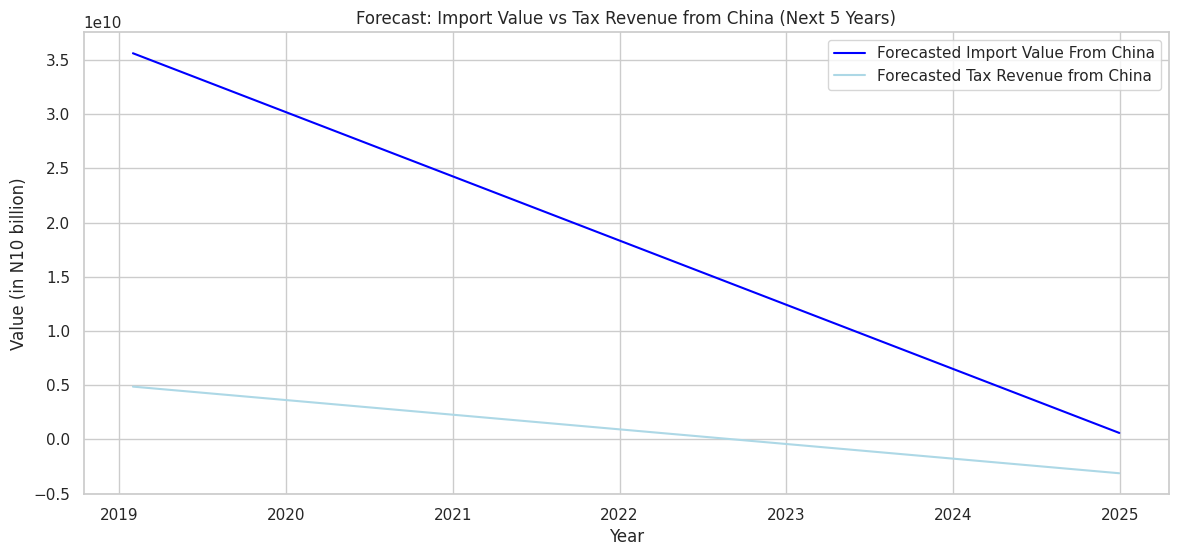

In [ ]:
# Filter data for China only
china_data = merged_data[merged_data['Country_of_Supply'] == 'China']

# Monthly total CIF and tax
china_monthly = china_data.groupby(pd.Grouper(key='Reg_Date', freq='ME'))[['CIF_Value(N)', 'Total_Tax(N)']].sum().reset_index()

# Forecast CIF_Value(N)
china_cif = china_monthly[['Reg_Date', 'CIF_Value(N)']].rename(columns={'Reg_Date': 'ds', 'CIF_Value(N)': 'y'})
china_model_cif = Prophet()
china_model_cif.fit(china_cif)
china_future_cif = china_model_cif.make_future_dataframe(periods=60, freq='ME')
china_forecast_cif = china_model_cif.predict(china_future_cif)

# Forecast Total_Tax(N)
china_tax = china_monthly[['Reg_Date', 'Total_Tax(N)']].rename(columns={'Reg_Date': 'ds', 'Total_Tax(N)': 'y'})
china_model_tax = Prophet()
china_model_tax.fit(china_tax)
china_future_tax = china_model_tax.make_future_dataframe(periods=60, freq='ME')
china_forecast_tax = china_model_tax.predict(china_future_tax)

# Visualize Forecast

plt.figure(figsize=(14, 6))
plt.plot(china_forecast_cif['ds'], china_forecast_cif['yhat'], label='Forecasted Import Value From China', color='blue')
plt.plot(china_forecast_tax['ds'], china_forecast_tax['yhat'], label='Forecasted Tax Revenue from China', color='lightblue')
plt.xlabel('Year')
plt.ylabel('Value (in N10 billion)')
plt.title('Forecast: Import Value vs Tax Revenue from China (Next 5 Years)')
plt.legend()
plt.grid(True)
last_row_c = china_forecast_tax.iloc[-1]
last_date_c = last_row_c['ds']
last_value_c = last_row_c['yhat']
plt.show()

### **5.3 Scenario Forecasting/Modelling**
- To simulate the impact of policy changes (e.g., tariffs or trade bans)

#### **5.3.1 Scenario 12% Reduction in Import Volume**

- Modelling the potential impact of a 12% reduction in forecasted import values, simulating the effect of successful import substitution, policy changes, or supply disruptions. This helps assess the fiscal implications of reduced import dependency and supports planning for strategic local production or innovation interventions.

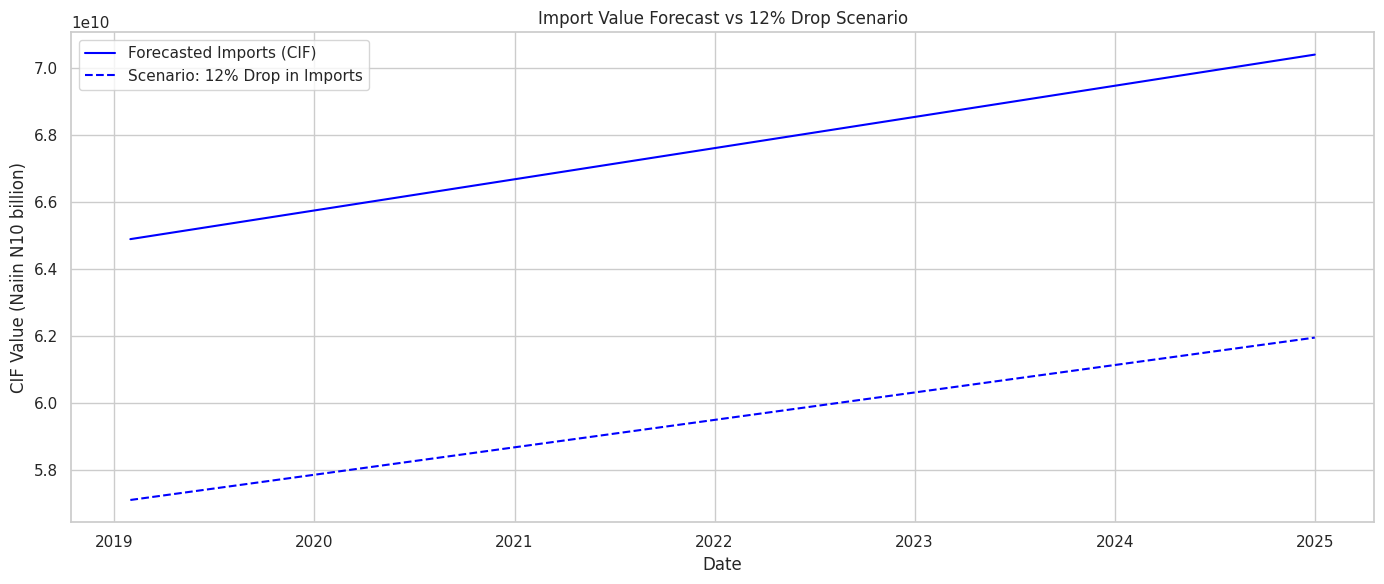

In [ ]:
# Apply 12% drop to forecasted import values
import_forecast['yhat_adj'] = import_forecast['yhat'] * 0.88

# Plot Import Forecast vs 12% Drop Scenario
plt.figure(figsize=(14, 6))
plt.plot(import_forecast['ds'], import_forecast['yhat'], label='Forecasted Imports (CIF)', color='blue')
plt.plot(import_forecast['ds'], import_forecast['yhat_adj'], label='Scenario: 12% Drop in Imports', color='blue', linestyle='--')
plt.title('Import Value Forecast vs 12% Drop Scenario')
plt.xlabel('Date')
plt.ylabel('CIF Value (Naiin N10 billion)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **5.3.2 Scenario 20% Reduction in Import Volume for Top Country of supply**

In [ ]:
# Apply 20% drop to China's forecasted import values
china_forecast_cif['yhat_adj'] = china_forecast_cif['yhat'] * 0.8

# Estimate tax revenue assuming same tax rate as historical average for China
historical_tax_rate_china = china_monthly['Total_Tax(N)'].sum() / china_monthly['CIF_Value(N)'].sum()
china_forecast_cif['Tax_Revenue_Estimated'] = china_forecast_cif['yhat_adj'] * historical_tax_rate_china

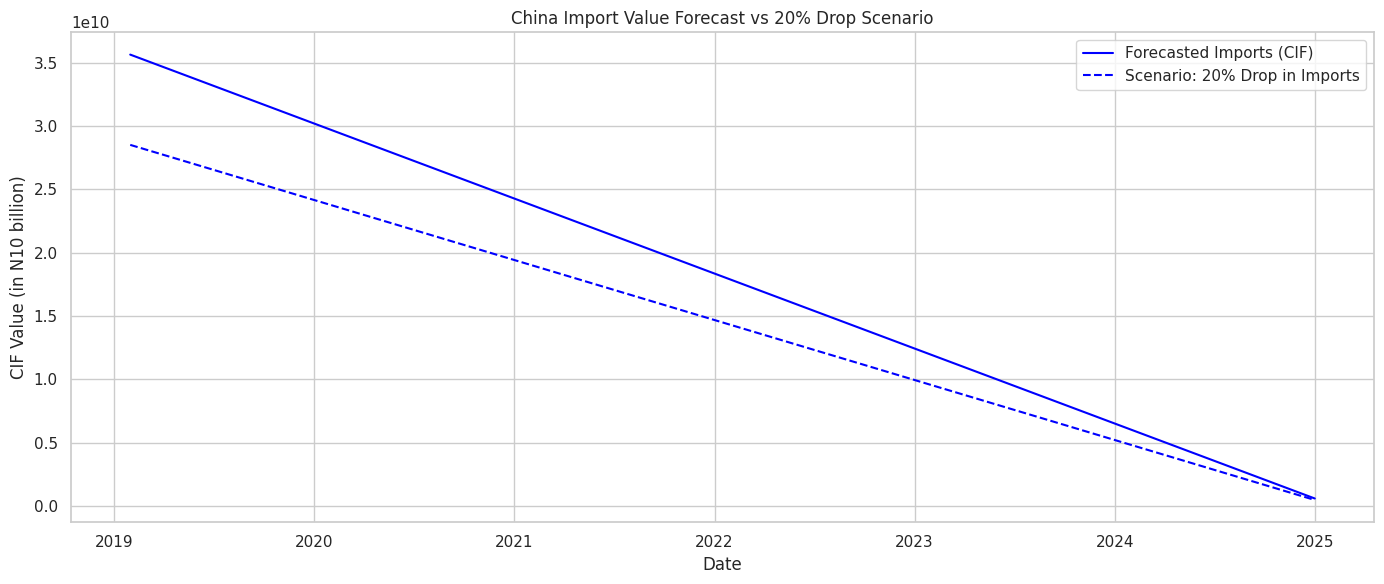

In [ ]:
# Plot China Import Forecast vs 20% Drop Scenario
plt.figure(figsize=(14, 6))
plt.plot(china_forecast_cif['ds'], china_forecast_cif['yhat'], label='Forecasted Imports (CIF)', color='blue')
plt.plot(china_forecast_cif['ds'], china_forecast_cif['yhat_adj'], label='Scenario: 20% Drop in Imports', color='blue', linestyle='--')
plt.title('China Import Value Forecast vs 20% Drop Scenario')
plt.xlabel('Date')
plt.ylabel('CIF Value (in N10 billion)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 ### **5.4 Identify Fast Growing Import Categories**

In [ ]:
# Monthly import volume by HS codes
# Group by HS_Code and Month
monthly_hscode = (
    merged_data
    .groupby([pd.Grouper(key='Reg_Date', freq='M'), 'HS_Code'])['CIF_Value(N)']
    .sum()
    .reset_index()
)

# Pivot data to have months as columns
pivot = monthly_hscode.pivot(index='HS_Code', columns='Reg_Date', values='CIF_Value(N)').fillna(0)

# Calculate the growth rate for each HS_Code using linear regression
growth_rates = []
total_imports = []

for hs_code in pivot.index:
    y = pivot.loc[hs_code].values
    X = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    growth_rates.append((hs_code, slope))

    # Calculate total import for each HS_Code (sum of CIF values)
    total_imports.append((hs_code, pivot.loc[hs_code].sum()))

# Create a DataFrame of HS_Code, their growth slopes, and total imports
hs_growth_df = pd.DataFrame(growth_rates, columns=['HS_Code', 'Growth_Slope'])
hs_growth_df['Growth_Slope'] = hs_growth_df['Growth_Slope'].round(2)
total_imports_df = pd.DataFrame(total_imports, columns=['HS_Code', 'Total_Import(N)']).round(2)
hs_growth_df = hs_growth_df.merge(total_imports_df, on='HS_Code', how='left')
hs_desc_df = merged_data[['HS_Code', 'HS_Description']].drop_duplicates()
hs_growth_df = hs_growth_df.merge(hs_desc_df, on='HS_Code', how='left').sort_values(by='Growth_Slope', ascending=False).reset_index(drop=True)

fastest_growing = hs_growth_df[['HS_Code', 'HS_Description', 'Growth_Slope', 'Total_Import(N)']].head(10)
print('Top 10 Fast Growing Categories')
fastest_growing

Top 10 Fast Growing Categories


,HS_Code,HS_Description,Growth_Slope,Total_Import(N)
0,8502111000,"Generating Sets, Diesel Or Semidiesel Engines,...",3.603721e+08,1.293321e+10
1,8541401000,Solar Cells Whether Or Not In Modules Or Made ...,2.694431e+08,2.609446e+10
2,8544600000,"Other Electric Conductors, For A Voltage Excee...",2.102708e+08,1.817378e+10
3,8537100000,"Boards, Panels, Consoles For Electric Control/...",1.976531e+08,2.285914e+10
4,8544491000,"Almenec Insulated Cables, Metallic Part Made O...",1.585894e+08,5.685176e+09
5,8536900000,Other Apparatus Of Heading 85.36 Not Specified,7.463709e+07,5.939956e+09
6,8530900000,Parts Of Article Of Heading 85.30,6.110017e+07,1.626849e+09
7,8542310000,"Processors And Controllers, Converters. Or Oth...",6.010500e+07,7.728600e+09
8,8517690000,Other Apparatus Of Subheading 8517.60 Not Spec...,5.592479e+07,4.003034e+09
9,8502139099,Of An Output Exceeding 1000Kva,5.021325e+07,1.165917e+10


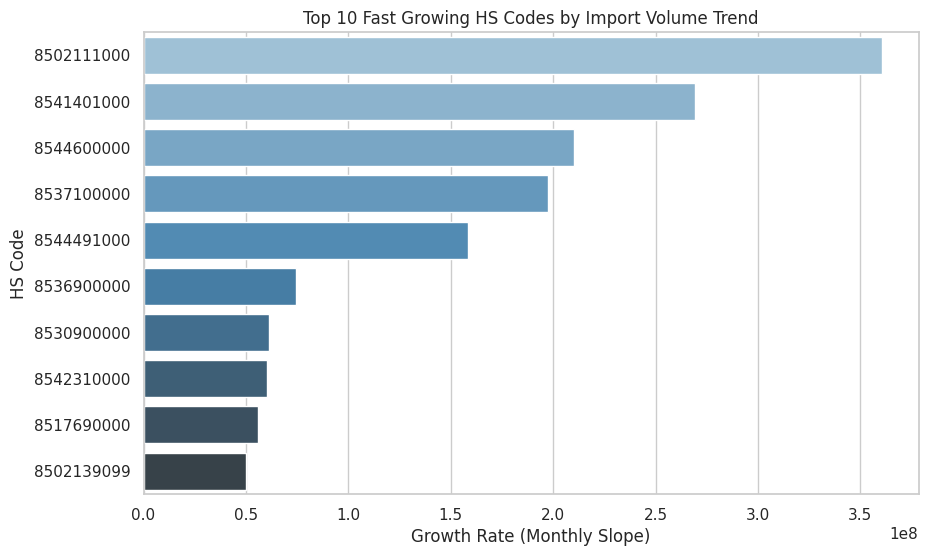

In [ ]:
# Visualize Top 10 Fast Growing HS Codes
plt.figure(figsize=(10, 6))
sns.barplot(data=fastest_growing, x='Growth_Slope', y='HS_Code', palette='Blues_d')
plt.title('Top 10 Fast Growing HS Codes by Import Volume Trend')
plt.xlabel('Growth Rate (Monthly Slope)')
plt.ylabel('HS Code')
plt.show()

### **5.5 Conclusion: Predictive Forecasting of Import Volume & Tax Revenue**

#### **Key Projections**
- **Import Value**:
  - 2019: ₦783B → 2024: ₦844B (7.8% growth)
- **Tax Revenue**:
  - 2019: ₦100B → 2024: ₦60B (40% decline)
  - Expected 2024: ₦112B (gap: ₦52B)

- **Top Supplier Risk**:
  - Projected fall: ₦420B (2019) → ₦7B (2024)
  - Tax revenue nears zero by 2024

#### **Scenario Modeling**
| Scenario | Impact | Fiscal Shortfall |
|----------|--------|------------------|
| 12% import drop (2020-2024) | Reduced trade volume | ₦449B cumulative |
| 20% drop from top supplier | Supply chain disruption | ₦154B over 5 years |

#### **Fast-Growing HS Codes**
1. `8502111000`: Diesel Generators (<75Kva)  
2. `8541401000`: Solar Panels/Cells  
3. `8544600000`: High-Voltage Conductors  

#### **Recommendations**
1. **Tax Efficiency**: Close loopholes in fast growing categories  
2. **Local Production**: Prioritize:  
   - Solar panels (local assembly incentives)
   - HV conductors (tariff protections)
3. **Early Warning**: Monitor top supplier decline (₦420B→₦7B)  

##  **6. Policy Impact Modeling for Import Substitution & Innovation**

### **6.1 Identifying HS Codes with Potential for Local Innovation or Production**

`Approach: high import volume and growth potential.`

We identified the fastest growing HS codes from the previous analysis, highlighting sectors with high potential for local production or innovation. These categories are key for reducing import dependency and driving industrial growth in Nigeria.

### **6.2 Estimating Fiscal and Industrial Impact of Substitution**
`Approach: Potential impacts of substituting imports with local products.`


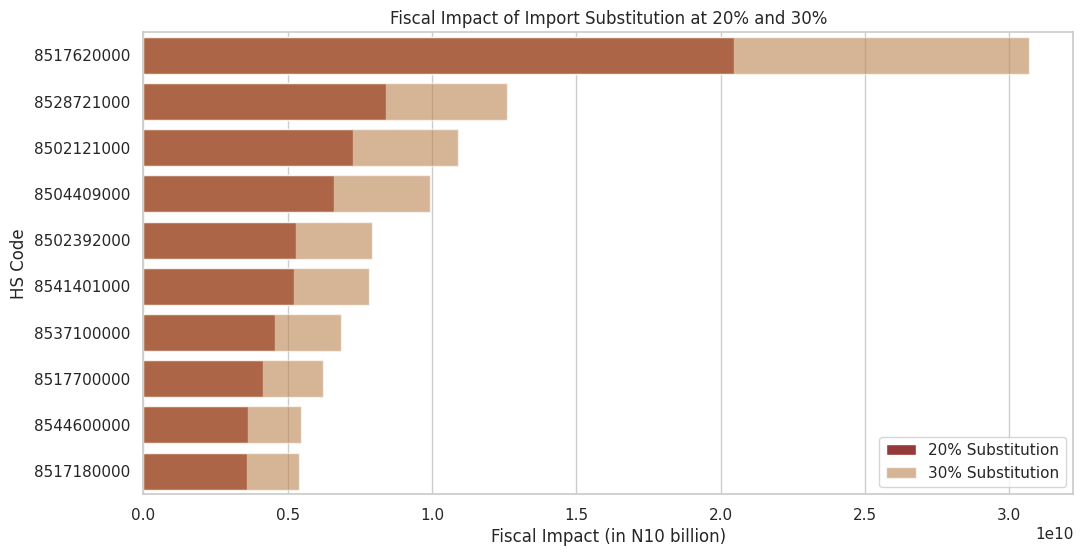

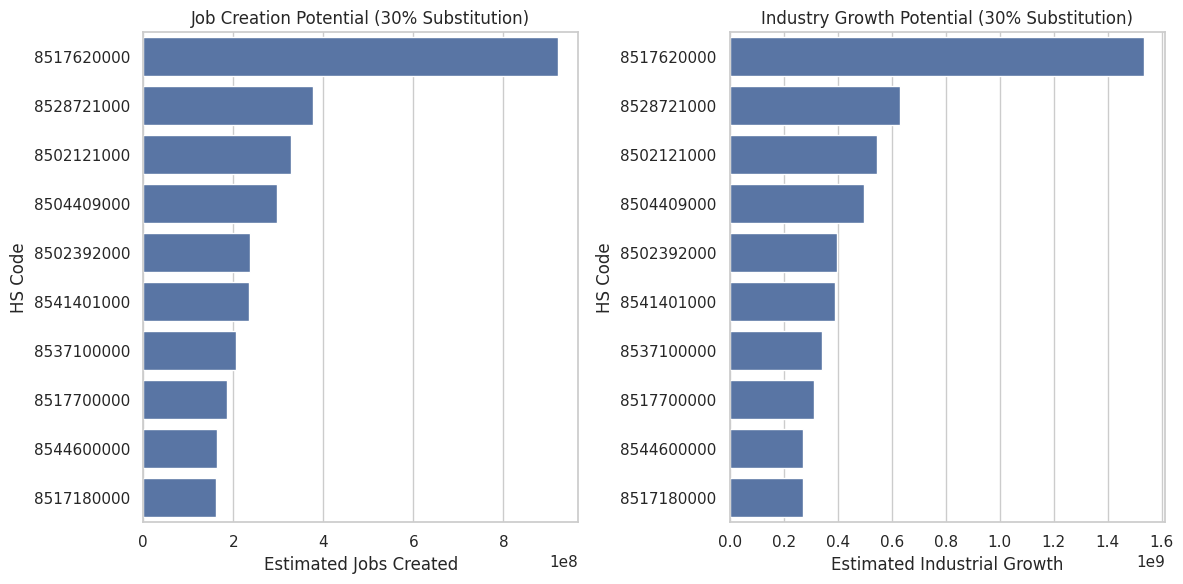

n Top 10 High Impact HS Codes 



np.float64(236333600609.7)

In [ ]:
# Estimate fiscal impact from import substitution for 20% and 30%
substitution_percentages = [0.2, 0.3]

# Calculate the fiscal impact (money saved from imports) for substitution
hs_growth_df['Fiscal_Impact_20'] = hs_growth_df['Total_Import(N)'] * substitution_percentages[0]
hs_growth_df['Fiscal_Impact_30'] = hs_growth_df['Total_Import(N)'] * substitution_percentages[1]
hs_growth_df = hs_growth_df.sort_values(by='Fiscal_Impact_30', ascending=False).reset_index(drop=True)

# Visualize fiscal impact for substitution at 20% and 30%
plt.figure(figsize=(12, 6))
sns.barplot(x='Fiscal_Impact_20', y='HS_Code', data=hs_growth_df.head(10), color='brown', label="20% Substitution")
sns.barplot(x='Fiscal_Impact_30', y='HS_Code', data=hs_growth_df.head(10), color='peru', label="30% Substitution", alpha=0.6)
plt.title('Fiscal Impact of Import Substitution at 20% and 30%')
plt.xlabel('Fiscal Impact (in N10 billion)')
plt.ylabel('HS Code')
plt.legend()
plt.show()

# Estimate potential job creation and industry growth
hs_growth_df['Job_Creation_30%'] = hs_growth_df['Fiscal_Impact_30'] * 0.03  # Assume 3% of fiscal impact is related to job creation
hs_growth_df['Industry_Growth_30%'] = hs_growth_df['Fiscal_Impact_30'] * 0.05  # Assume 5% is related to industrial growth

# Visualize job creation and industry growth
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Job creation plot at 30% substitution
sns.barplot(x='Job_Creation_30%', y='HS_Code', data=hs_growth_df.head(10), ax=axes[0])
axes[0].set_title('Job Creation Potential (30% Substitution)')
axes[0].set_xlabel('Estimated Jobs Created')
axes[0].set_ylabel('HS Code')

# Industry growth plot at 30% substitution
sns.barplot(x='Industry_Growth_30%', y='HS_Code', data=hs_growth_df.head(10), ax=axes[1])
axes[1].set_title('Industry Growth Potential (30% Substitution)')
axes[1].set_xlabel('Estimated Industrial Growth')
axes[1].set_ylabel('HS Code')

plt.tight_layout()
plt.show()

print('n Top 10 High Impact HS Codes \n')
hs_growth_df['Fiscal_Impact_30'].sum()

In [ ]:
total_savings_30 = hs_growth_df['Fiscal_Impact_30'].sum()
total_job_creation = hs_growth_df['Job_Creation_30%'].sum()
total_industry_growth = hs_growth_df['Industry_Growth_30%'].sum()

print(f"Estimated Total Fiscal Savings (30% Substitution): ₦{total_savings_30:,.0f}")
print(f"Estimated Job Creation Activity: ₦{total_job_creation:,.0f}")
print(f"Estimated Industrial Growth: ₦{total_industry_growth:,.0f}")

Estimated Total Fiscal Savings (30% Substitution): ₦236,333,600,610
Estimated Job Creation Activity: ₦7,090,008,018
Estimated Industrial Growth: ₦11,816,680,030


### **6.3 Allocating Funds based on Import Sensitivity, Value, and National Piorities**

The National Priority Score was calculated based on three factors:

- Gov. Initiative Score (0-5): Reflects alignment with national priorities.

- Employment Potential (0-5): Assesses the job creation potential of each product.

- Local Production Feasibility (0-5): Evaluates how feasible it is to produce the product locally.

- Scores are adjusted for non-clean energy sources, reducing their score by 0.3 points. The National Priority Score is the average of these three criteria.


| HS Code       | Description                                                | Gov. Initiative | Employment Potential | Local Feasibility | National Priority Score |
|---------------|--------------------------------------------------------------------|------------------|------------------------|--------------------|--------------------------|
| 8541401000    | Solar Cells Whether or Not in Modules or Made Up Into Panels      | 5                | 4                      | 4                  | **4.33**                 |
| 8504409000    | Other Static Converters Not Specified (e.g., inverters, UPS)      | 4                | 4                      | 3                  | **3.67**                 |
| 8544600000 | Other Electric Conductors, For A Voltage Exceeding 1,000 V        | 3                | 4                      | 3                  | **3.33**                 |
| 8537100000    | Panels for Control/Distribution < 1,000 V                | 2                | 3                      | 4                  | **3.00**                 |
| 8502121000    | Diesel Generator >75<375Kva, CKD for Assembly                     | 3                | 3                      | 3                  | **2.67**                 |
| 8502392000    | Gas-powered Generator                                              | 3                | 3                      | 2                  | **2.67**                 |
| 8517700000    | Parts Of Articles Of Heading 8517 (e.g., telecom components)      | 2                | 3                      | 3                  | **2.67**                 |
| 8528721000    | Reception Apparatus For Television, Coloured, CKD                | 2                | 3                      | 3                  | **2.67**                 |
| 8517180000| Other Telephone Sets Not Specified                                | 2                | 3                      | 3                  | **2.67**                 |
8517620000|Machines For Reception, Conversion And Transmission Of Voice, Images Or Data.                               | 5               | 4                      | 2                 | **3.67**                 |

Fund Allocation for Key HS Codes


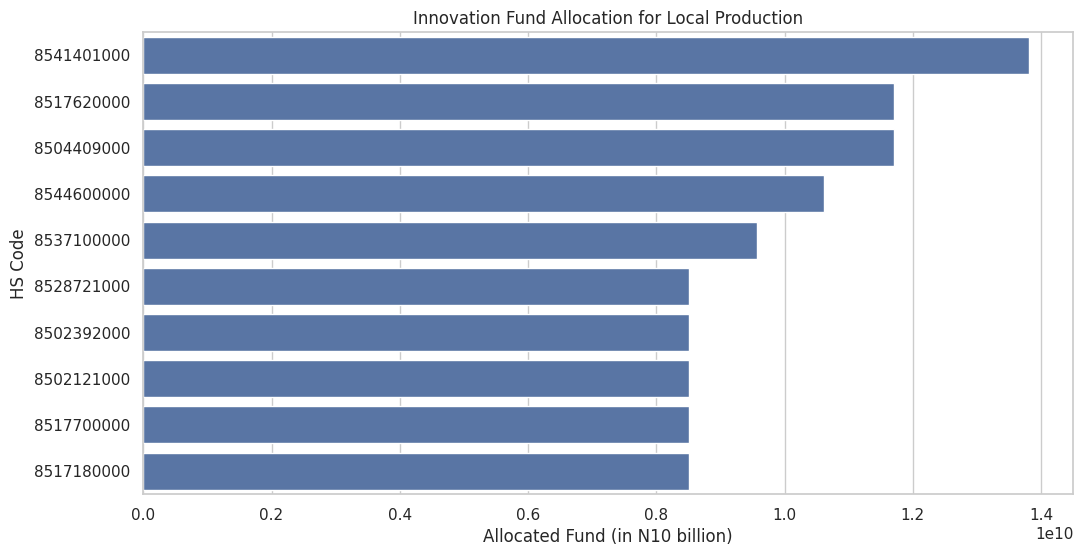

Top 10 HS Codes for Fund Allocation


,HS_Code,HS_Description,Priority_Score,Fiscal_Impact_30,Allocated_Fund
0,8541401000,Solar Cells Whether Or Not In Modules Or Made ...,4.33,7.828339e+09,1.381180e+10
1,8517620000,"Machines For Reception, Conversion And Transmi...",3.67,3.068386e+10,1.170654e+10
2,8504409000,Other Static Converters Not Specified,3.67,9.936822e+09,1.170654e+10
3,8544600000,"Other Electric Conductors, For A Voltage Excee...",3.33,5.452133e+09,1.062201e+10
4,8537100000,"Boards, Panels, Consoles For Electric Control/...",3.00,6.857742e+09,9.569378e+09
5,8528721000,"Reception Apparatus For Television, Coloured, ...",2.67,1.258872e+10,8.516746e+09
6,8502392000,Gaspowered Generator,2.67,7.914023e+09,8.516746e+09
7,8502121000,"Gen. Set, Diesel Or Semidiesel Engine, Output ...",2.67,1.091808e+10,8.516746e+09
8,8517700000,Parts Of Article Of Heading 8517,2.67,6.226885e+09,8.516746e+09
9,8517180000,Other Telephone Sets Not Specified.,2.67,5.410342e+09,8.516746e+09


In [ ]:
# Get Top 10 high Impact HS Codes
top10_hs_growth_df = hs_growth_df.sort_values(by='Fiscal_Impact_30', ascending=False).reset_index(drop=True).head(10)
top10_hs_growth_df[['HS_Code', 'HS_Description']]

# Create DataFrame with HS codes and priority scores
priority_df = pd.DataFrame({
    'HS_Code': [
        '8517620000', '8528721000', '8502121000', '8504409000', '8502392000',
        '8541401000', '8537100000', '8517700000', '8544600000', '8517180000'
    ],
    'Priority_Score': [
        3.67, 2.67, 2.67, 3.67, 2.67,
        4.33, 3.00, 2.67, 3.33, 2.67
    ]
})

#  Merge with top10 HS growth data
fund_df = top10_hs_growth_df.merge(priority_df, on='HS_Code', how='left')

#  Normalize scores
fund_df['Normalized_Score'] = fund_df['Priority_Score'] / fund_df['Priority_Score'].sum()

#  Allocate funds (₦100 billion)
total_fund = 100000000000
fund_df['Allocated_Fund'] = (fund_df['Normalized_Score'] * total_fund).round(2)

# Display key result columns
print('Fund Allocation for Key HS Codes')
fund_df = fund_df.sort_values(by='Allocated_Fund', ascending=False).reset_index(drop=True)

# Visualize fund allocation
plt.figure(figsize=(12, 6))
sns.barplot(x='Allocated_Fund', y='HS_Code', data=fund_df)
plt.title('Innovation Fund Allocation for Local Production')
plt.xlabel('Allocated Fund (in N10 billion)')
plt.ylabel('HS Code')
plt.show()

print('Top 10 HS Codes for Fund Allocation')
fund_df[['HS_Code', 'HS_Description', 'Priority_Score', 'Fiscal_Impact_30', 'Allocated_Fund']]

### **6.4 Conclusion: Policy Impact Modeling for Import Substitution & Innovation**

#### **Key Insights**
- **High-Growth HS Codes**:
  - Solar cells (`8541401000`)
  - Electric control panels (`8537109000`)
  - Diesel generators (`8502111000`)

- **Fiscal Impact (30% Substitution)**:
  - Total savings: **₦236.33B**
  - Top categories: Generators, solar tech

- **Economic Multipliers (30% Substitution)**:
  - Job creation: **₦7.09B**
  - Industrial growth: **₦11.82B**

#### **Optimal ₦100B Fund Allocation**
| Priority Sector          | Allocation (₦B) |
|--------------------------|-----------------|
| Solar Cells              | 13.8            |
| Data Transmission        | 11.7            |
| Static Converters        | 11.7            |
| Electric Conductors      | 10.6            |
| Control Panels           | 9.6             |

#### **Recommendations**
1. **Local Production Push**:
   - Target: Solar tech + control systems
   - Leverage: ₦100B fund allocation

2. **Fiscal Incentives**:
   - Tax breaks for high impact HS code alternatives

3. **Industrial Clusters**  
   - Energy tech hub (Solar/conductors)  
   - Electronics hub (Control systems)

4. **Job Linkages**:
   - Tie 30% substitution to **₦7.09B** job creation target

In [ ]:
# Exporting the key dataframes to CSV

# Extract relevant columns from the import forecast

import_forecast_data = import_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_adj']].rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_CIF_Value(N)',
    'yhat_lower': 'Confidence_Interval_Lower',
    'yhat_upper': 'Confidence_Interval_Upper',
    'yhat_adj': 'Forecasted_CIF_Value_Adjusted'
})
import_forecast_data['Year'] = import_forecast_data['Date'].dt.year
import_forecast_data['Month'] = import_forecast_data['Date'].dt.month

tax_forecast_data = tax_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Tax_Revenue(N)',
    'yhat_lower': 'Confidence_Interval_Lower',
    'yhat_upper': 'Confidence_Interval_Upper',
})

tax_forecast_data['Year'] = tax_forecast_data['Date'].dt.year
tax_forecast_data['Month'] = tax_forecast_data['Date'].dt.month

import_forecast_data.to_csv('forecasted_imports.csv', index=False)
tax_forecast_data.to_csv('forecasted_tax_revenue.csv', index=False)
merged_data.to_csv('merged_data.csv', index=False)
hs_growth_df.to_csv('hs_growth_df.csv', index=False)
fund_df.to_csv('fund_df.csv', index=False)

print("Forecast data for import volume and tax revenue has been successfully exported!")

Forecast data for import volume and tax revenue has been successfully exported!


## **7 Conclusion & Strategic Recommendations**

### **Why This Matters**
- **Critical Trends**:
  - Import growth (→ ₦844B by 2024) vs tax decline (→ ₦60B)
  - 12-20% import reductions risk ₦154-449B fiscal shortfalls
- **Urgent Opportunities**:
  - Fast-growing sectors: Solar cells (`8541401000`), HV conductors (`8544600000`)

### **Projected Impact** *(30% Substitution Scenario)*
| Metric                | Value            |
|-----------------------|------------------|
| Fiscal Savings        | ₦236.33 B             |
| Job Creation          | ₦7.09 B          |
| Industrial Growth     | ₦11.82 B           |

### **Action Plan**
1. **Policy Infrastructure**:
   - Institutionalize data driven forecasting for trade decisions
   - Real-time tax gap monitoring (Current gap: ₦8.86B)

2. **Immediate Interventions**:
   - Target solar tech (₦13.8B allocation) and cable manufacturing
   - Strengthen Tin Can/Apapa customs (₦6.46B leakage address)

3. **Long-term Shifts**:
   - Industrial clusters for:
     - Energy (Solar/conductors)
     - Electronics (Control systems)
   - Tie **₦100 B** innovation fund to measurable impact metrics (fiscal savings, jobs, local production)


*Analysis note: Forecasts based on time-series trend analysis of 2019-2024 data*

## **8. References and Links**
[GITHUB](https://github.com/nifemifaith07/ZTH_Reform_Analytics_Hackathon.git)
[DRIVE](https://drive.google.com/drive/folders/1KH0RgM0lzzHW_j7V8E6WdBoQLuYCz_tU?usp=drive_link)
[POWERBI](https://app.powerbi.com/links/n0ziMDLWbP?ctid=66b3f0c2-8bc6-451e-9603-986f618ae682&pbi_source=linkShare)
[NOTEBOOK](https://colab.research.google.com/drive/1RyCaCtG7I-S0wTNKjfLj-rzrC_jjoW-y)
[TRADE PORTAL](https://trade.gov.ng/en/downloads)